# US Stock Market
In this notebook I look at:
* the market capitalization of listed domestic companies in the US
* the market capitalization of listed domestic companies in the US as percentage of US GDP
* the total annual value of stocks traded on US exchanges
* the total annual value of stocks traded on US exchanges as percentage of US GDP
* the total number of listed domestic companies in the US as well as foreign companies that are exclusively listed on US exchanges
* the annual volatility of the subset of the market represented by the S&P 500 index
* the forward annual dividend yield of S&P 500
* the forward price to earnings ratio of S&P 500
* the P/B and ROEs of banks from S&P 500 and their cost of equity

The only publically available source of these data is [The World Bank](https://data.worldbank.org). Unfortunately it only provides data at annual granularity rather than quarterly or monthly. To compensate for it I created my own module called `stock_market.metrics` (which is part of this repository) where I calculate capitalization, turnover, forward dividend yields and volatility of an arbitrary stock market with the help of the [yfinance](https://pypi.org/project/yfinance/) module. I use it to provide metrics on a subset of the US stock market represented by companies that are part of the [S&P 500 Index](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies).

Given that the S&P 500 Index makes up approximately 84% of the US listed domestic companies, it's a pretty representative alternative. Given the amount of data that needs to be retrieved, I limit the analysis of S&P 500 to the year 2020 and onwards. I carry out the analysis at monthly granularity.

All amounts are represented in either Billions of USD or as percentage points.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
#!git clone -l -s https://github.com/ilchen/US_Economic_Data_Analysis.git cloned-repo
#%cd cloned-repo

# Install the latest version of pandas-datareader and yfinance
# !pip install pandas-datareader -U
# !pip install yfinance -U

In [2]:
import pandas as pd
from pandas.tseries.offsets import YearBegin
import numpy as np
import scipy
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from pandas_datareader import wb

from datetime import date

from stock_market import metrics

In [3]:
report_start = date.fromisoformat('1959-01-01')
report_end = date.today()

In [4]:
stock_mkt = wb.download(indicator=['CM.MKT.LCAP.CD', 'CM.MKT.LCAP.GD.ZS', 'CM.MKT.TRAD.CD', 'CM.MKT.TRAD.GD.ZS',
                                   'CM.MKT.TRNR', 'CM.MKT.LDOM.NO'],
                        country='US', start=report_start, end=report_end).loc['United States'].dropna(how='all')
stock_mkt.index = pd.to_datetime(stock_mkt.index).shift(1, 'YE')
stock_mkt = stock_mkt.asfreq('YE')

# Convert into billions of USD
stock_mkt.loc[:, ['CM.MKT.LCAP.CD', 'CM.MKT.TRAD.CD']] /= 1e9

# Convert to percentage points
stock_mkt.loc[:, ['CM.MKT.LCAP.GD.ZS', 'CM.MKT.TRAD.GD.ZS', 'CM.MKT.TRNR']] /= 100.

/var/folders/8s/xmctpx8d1m124s21678721y00000gn/T/ipykernel_1249/379950046.py:1: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  stock_mkt = wb.download(indicator=['CM.MKT.LCAP.CD', 'CM.MKT.LCAP.GD.ZS', 'CM.MKT.TRAD.CD', 'CM.MKT.TRAD.GD.ZS',


In [5]:
# ts = pd.to_datetime('2025-12-31')
# if stock_mkt.index[-1] < ts:
    # Small adjustment for not yet published data for US market capitalization at the end of 2025
    # stock_mkt.loc[ts, 'CM.MKT.LCAP.CD'] = 50781.6975
    # gdp = web.get_data_fred('GDPA', start=report_start, end=report_end)
    # gdp.index = gdp.index.shift(1, 'YE')
    # gdp = gdp.asfreq('YE')
    # stock_mkt.loc[ts, 'CM.MKT.LCAP.GD.ZS'] = stock_mkt.loc[ts, 'CM.MKT.LCAP.CD'] / gdp.GDPA.loc[ts]

In [6]:
# Human readable column names for DataFrames
MKT_CAP = 'Market capitalization of listed domestic companies'
MKT_CAP_TO_GDP = MKT_CAP + ' (% of GDP)'
MKT_CAP_GRAPH_TITLE = 'US ' + MKT_CAP
MKT_CAP_SP500 = 'Market capitalization of S&P 500 companies'
MKT_CAP_SP500_TO_GDP = MKT_CAP_SP500 + ' (% of GDP)'
MKT_CAP_TOP10_SP500 = 'Top-10 S&P 500 companies by market capitalization and their share of S&P 500'
TRAD_VOL = 'Stocks traded, total value'
TRAD_VOL_TO_GDP = TRAD_VOL + ' (% of GDP)'
TRAD_VOL_GRAPH_TITLE = 'US ' + TRAD_VOL + ' (annual)'
TRAD_VOL_SP500_GRAPH_TITLE = 'S&P 500 ' + TRAD_VOL + ' (annualized)'
TRAD_VOL_SP500_GRAPH_TITLE_DAILY = 'S&P 500 ' + TRAD_VOL + ' (average daily)'
TUROVER_RATIO = 'Turnover ratio of domestic shares (%)'
TUROVER_RATIO_GRAPH_TITLE = 'US Stocks traded, Annual ' + TUROVER_RATIO
TUROVER_RATIO_SP500 = 'Turnover ratio of S&P 500 companies (%)'
TUROVER_RATIO_SP500_GRAPH_TITLE = 'Stocks traded, Annual ' + TUROVER_RATIO_SP500
TUROVER_RATIO_SP500_DAILY_GRAPH_TITLE = 'Stocks traded, Daily ' + TUROVER_RATIO_SP500
VOLATILITY_SP500 = 'Volatility of S&P 500'
EXCESS_RETURN_SP500 = 'Excess Annual Return of S&P 500 over 1-year Riskless rate'
SHARPE_RATIO_SP500 = 'Sharpe Ratio of S&P 500 (with volatility over {:d} years)'
NUM_LISTED_DOMESTIC = 'Number of listed domestic companies'
NUM_LISTED_DOMESTIC_GRAPH_TITLE = 'US Listed domestic companies, total'

# Y axis labels for graphs
LEFT_Y_AXIS_LABEL = 'Billions of USD'
RIGHT_Y_AXIS_LABEL = '% of GDP'

TTM_SUFFIX = ' (ttm)'
MRQ_SUFFIX = ' (mrq)'

In [7]:
stock_mkt.rename(
    columns={'CM.MKT.LCAP.CD': MKT_CAP, 'CM.MKT.LCAP.GD.ZS': MKT_CAP_TO_GDP,
             'CM.MKT.TRAD.CD': TRAD_VOL, 'CM.MKT.TRAD.GD.ZS': TRAD_VOL_TO_GDP,
             'CM.MKT.TRNR': TUROVER_RATIO, 'CM.MKT.LDOM.NO': NUM_LISTED_DOMESTIC},
    inplace=True)

In the below table **_Stocks traded, total value_** represents a cumulative annual amount of all transactions in listed domestic US equities.

In [8]:
pd.options.display.float_format = (lambda x: '{:.2%}'.format(x) if abs(x) < 5 else '${:,.2f}bn'.format(x))
pd.options.display.max_rows = 40
stock_mkt.iloc[:,:4]

,Market capitalization of listed domestic companies,Market capitalization of listed domestic companies (% of GDP),"Stocks traded, total value","Stocks traded, total value (% of GDP)"
year,,,,
1975-12-31,$703.80bn,41.77%,$137.28bn,8.15%
1976-12-31,$883.10bn,47.14%,$173.32bn,9.25%
1977-12-31,$834.24bn,40.07%,$165.87bn,7.97%
1978-12-31,$861.96bn,36.65%,$225.84bn,9.60%
1979-12-31,$993.59bn,37.82%,$271.85bn,10.35%
...,...,...,...,...
2020-12-31,"$41,569.86bn",197.38%,"$41,086.46bn",195.09%
2021-12-31,"$48,548.54bn",208.23%,"$45,874.15bn",196.76%
2022-12-31,"$40,297.98bn",157.38%,"$44,315.89bn",173.08%


For the S&P 500 index I obtain data directly from Yahoo-Finance. For the current list of S&P 500 constituent companies I use Wikipedia. The index actually contains 503 stocks since it includes two share classes of stock from 3 of its component companies.

In the `stock_market.metrics` module (which is part of this repository), I reconstruct the historical composition of the S&P 500 Index all the way to the start of 2020 based on my analysis of the changes to [the list of S&P 500 companies published on Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies#Selected_changes_to_the_list_of_S&P_500_components), which you can see in [this csv file](./stock_market/sp500_changes_since_2019.csv). For retrieving historical closing prices and volumes of delisted stocks I made use of [Alpha Vantage APIs](https://www.alphavantage.co/documentation/), which requires an API key to call. I saved retrived closing prices and volumes of delisted shares in the `csv` format as part of this repository to obviate the need to call this rate-limited API. I do a lot of heavy lifting in the `stock_market.metrics.Matrics` class to repair an occasionally incorrect number of shares outstanding reported by `yfinance` as well as needless adjustment for stock splits that Yahoo-Finance reports in unadjusted close prices.

In case you get an error:
> ValueError: The AlphaVantage API key must be provided either through the api_key variable or through the environment variable ALPHAVANTAGE_API_KEY

please run the below cell one more time. This is caused by Yahoo-Finance API not being able to download outstanding shares data or historcial prices data for a particular ticker symbol. In case you get it repeatedly, it means that
Yahoo-Finance no longer publishes data for a ticket symbol that got delisted. You will then need to obtain an API key for Alpha Vantage and set the `ALPHAVANTAGE_API_KEY` environment variable to the value of your key when running the below cell.

**NB:** The below cell will produce a warning about failure to download data for some ticker symbols. This is caused by the shares of these companies being delisted. They surely are no longer part of S&P 500 but some time ago they were. You need not worry about these warnings as I have stored historical closing prices of these stocks (along with their historical shares outstanding) as part of this repository.

Due to Yahoo-Finance's measures to restrict its public APIs' use, the `yfinance` library implemented built-in rate limiting support. This results in the below cell taking on average 6 minutes to complete. `yfinance` also stepped up the amount of logging it produces when you attempt to get data for a ticker that got delisted. In this notebook I am tracking the S&P 500 since the beginning of 2020 and there have been around 35 companies whose tickers got delisted since. Please don't be alarmed by an occasional warning that a ticker is _possibly delisted; no timezone found_.

In [9]:
start = date(2020, 1, 1)
sp500_hist_comps = metrics.USStockMarketMetrics.get_sp500_historical_components(start)
_, additional_share_classes = metrics.USStockMarketMetrics.get_sp500_components()
sp500_hist_shares_outs = metrics.USStockMarketMetrics.get_sp500_historical_shares_outstanding()
sp500_metrics = metrics.USStockMarketMetrics(sp500_hist_comps, additional_share_classes, start=start,
                                             hist_shares_outs=sp500_hist_shares_outs)

[*                      2%                       ]  10 of 606 completed$KSU: possibly delisted; no timezone found
[*                      2%                       ]  11 of 606 completed$FLIR: possibly delisted; no timezone found
[*                      2%                       ]  12 of 606 completed$TIF: possibly delisted; no timezone found
[*                      2%                       ]  15 of 606 completed$JNPR: possibly delisted; no timezone found
[**                     4%                       ]  26 of 606 completed$DISCK: possibly delisted; no timezone found
[*******               14%                       ]  86 of 606 completed$CTLT: possibly delisted; no timezone found
[*******               14%                       ]  87 of 606 completed$WBA: possibly delisted; no price data found  (1d 2020-01-01 -> 2026-01-02) (Yahoo error = "No data found, symbol may be delisted")
[*******               15%                       ]  88 of 606 completed$DISH: possibly delisted; no timezone

Correcting the number of shares outstanding for BX from 1227058813 to 738450871
Correcting the number of shares outstanding for BIO from 26974835 to 21906399
Correcting the number of shares outstanding for CVNA from 216803442 to 116947000
Correcting the number of shares outstanding for NWSA from 583819468 to 371779548
Correcting the number of shares outstanding for BRK-B from 2157334746 to 1372820139
	Extra correction for the number of shares outstanding for BRK-B from 2020-01-02 to 2024-07-23
Correcting the number of shares outstanding for EL from 360360240 to 245852896
	Extra correction for the number of shares outstanding for EL from 2020-01-02 to 2021-08-20
Correcting the number of shares outstanding for UA from 437369458 to 200604976
Correcting the number of shares outstanding for HSY from 202785122 to 148171608
Correcting the number of shares outstanding for NKE from 1478201363 to 1189313611
Correcting the number of shares outstanding for RL from 60640658 to 38759382
Correcting t

[*********************100%***********************]  1 of 1 completed


In [10]:
# Convert into billions of USD
sp500_capitalization = sp500_metrics.get_capitalization(frequency='ME', method='last') / 1e9
sp500_annual_trading_value = sp500_metrics.get_annual_trading_value(frequency='ME') / 1e9
sp500_daily_trading_value = sp500_metrics.get_daily_trading_value(frequency='ME') / 1e9

# The following three are already expressed in percentage points
sp500_daily_turnover = sp500_metrics.get_daily_turnover(frequency='ME')
sp500_annual_turnover = sp500_metrics.get_annual_turnover(frequency='ME')

use_VIX_implied_volatility = True
sp500_volatility = sp500_metrics.get_annual_volatility(frequency='ME', include_next_month=use_VIX_implied_volatility)

In [11]:
# Upsampling to monthly frequencies to match the frequency of S&P 500 metrics
gdp = web.get_data_fred('GDP', start=start, end=report_end).GDP.resample('ME').ffill()
missing_months = sp500_capitalization.index.difference(gdp.index)
gdp = pd.concat([gdp, pd.Series(np.nan, index=missing_months)]).sort_index().ffill()

In [12]:
stock_mkt_sp500 = pd.concat([sp500_capitalization, sp500_capitalization / gdp,
                             sp500_annual_trading_value, sp500_annual_trading_value / gdp,
                             sp500_daily_turnover, sp500_volatility], axis=1)
stock_mkt_sp500.columns = [MKT_CAP_SP500, MKT_CAP_SP500_TO_GDP, TRAD_VOL, TRAD_VOL_TO_GDP,
                           TUROVER_RATIO_SP500, VOLATILITY_SP500]
stock_mkt_sp500.dropna(inplace=True)

In the below table **_Stocks traded, total value_** represents a cumulative annual amount of all transactions in  equities that are part of the S&P 500 Index. **_Turnover ratio of S&P 500 companies_** represents the percentage of shares outstanding that are traded per day.

In [13]:
stock_mkt_sp500

,Market capitalization of S&P 500 companies,Market capitalization of S&P 500 companies (% of GDP),"Stocks traded, total value","Stocks traded, total value (% of GDP)",Turnover ratio of S&P 500 companies (%),Volatility of S&P 500
Date,,,,,,
2020-01-31,"$27,912.23bn",128.32%,"$43,194.86bn",198.59%,0.60%,8.21%
2020-02-29,"$25,533.56bn",117.39%,"$46,224.45bn",212.51%,0.73%,13.98%
2020-03-31,"$22,358.05bn",102.79%,"$76,218.84bn",350.41%,1.27%,62.41%
2020-04-30,"$25,154.77bn",126.04%,"$53,886.12bn",269.99%,0.90%,65.52%
2020-05-31,"$26,286.06bn",131.70%,"$48,085.74bn",240.93%,0.79%,42.86%
...,...,...,...,...,...,...
2025-08-31,"$57,476.10bn",184.84%,"$93,232.75bn",299.83%,0.65%,11.36%
2025-09-30,"$60,019.63bn",193.02%,"$105,779.02bn",340.18%,0.71%,9.30%
2025-10-31,"$61,004.30bn",196.19%,"$118,130.54bn",379.90%,0.71%,11.02%


## Market capitalization of listed domestic companies and its ratio to GDP
These measures allow to assess how overpriced the US stock market is. When the market capitalization in a given economy is more or less the same as the GDP, the market is considered fairly priced, higher capitalizations are deemed expensive. However, different markets have different norms of what is cheap or expensive when it comes to stock market capitalization to GDP ratios. The US stock market receives an extra premium thanks to its remarkable historical growth, high standards of corporate governanance, high volumes and liquidity.

**NB**: the market capitalizaion to GDP ratio only tells how cheap or expensive the overall stock market is. Even when the whole market is overpriced, it can contain adequately priced individual stocks.

It is customary to report stock market capitalization using the value on the last day of the period, providing a snapshot for consistency and comparison. Market capitalization values provided for a given year represent end of year capitalization of US listed domestic companies. Likewise capitalization values provided for a given month are end of month numbers. All dollar amounts are expressed in nominal terms, without adjustment for inflation.

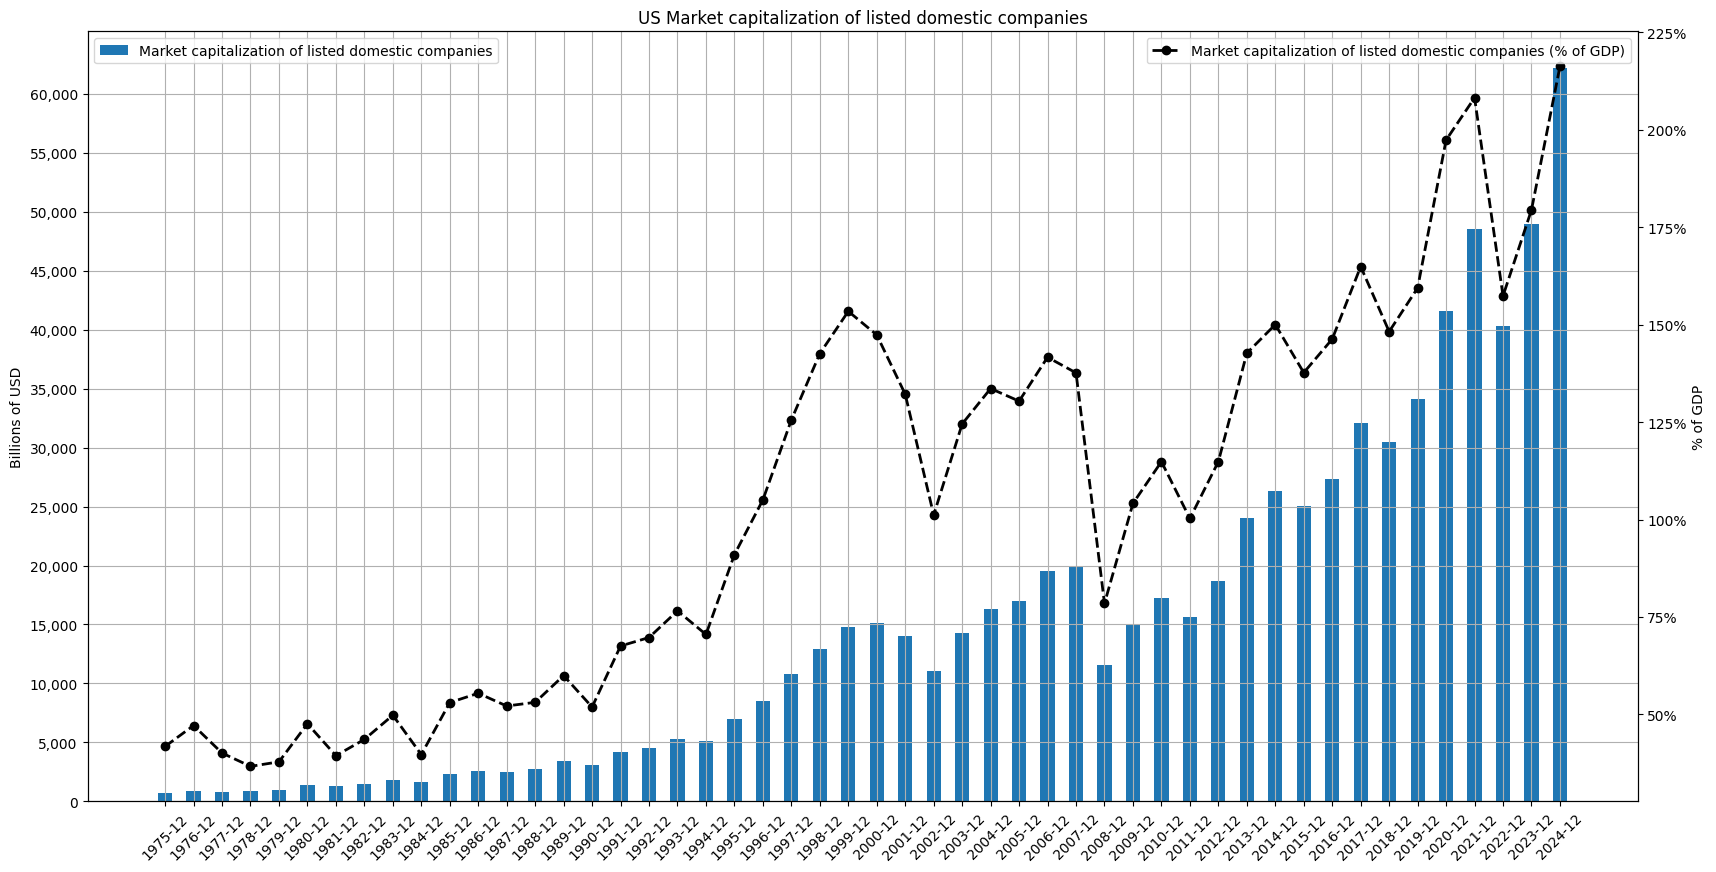

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
y_step = 5000
y_max = stock_mkt.iloc[:,0].max()
y_max = y_max + y_max % y_step + 1
ax2 = ax.twinx()
ax.bar(x=range(len(stock_mkt)), height=stock_mkt.iloc[:,0], color='#1f77b4', width=0.5, label=MKT_CAP)
ax2.plot(range(len(stock_mkt)), stock_mkt.iloc[:,1], color='k', marker='o', label=MKT_CAP_TO_GDP,
         linestyle='--', linewidth=2)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.title.set_text(MKT_CAP_GRAPH_TITLE)
ax.grid(True)
_ = ax.set_xticks(range(len(stock_mkt)), stock_mkt.index)
_ = ax.set_xticklabels(stock_mkt.index.strftime('%Y-%m'), rotation=45)
ax.set_yticks(np.arange(0, y_max, y_step))
ax.set_ylabel(LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax2.set_ylabel(RIGHT_Y_AXIS_LABEL)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))

### Market capitalization of listed domestic companies that are part of S&P 500 Index and its ratio to GDP
This is almost the same as the above graph except that here I limit the analysis to the subset of US listed equities that are part of the S&P 500 Index. This is approximately 84% of the total US listed domestic companies as of end of 2024. Given my own implementation in the `stock_market.metrics` module, I am able to carry out this analysis at monthly frequences, including the most recent month.

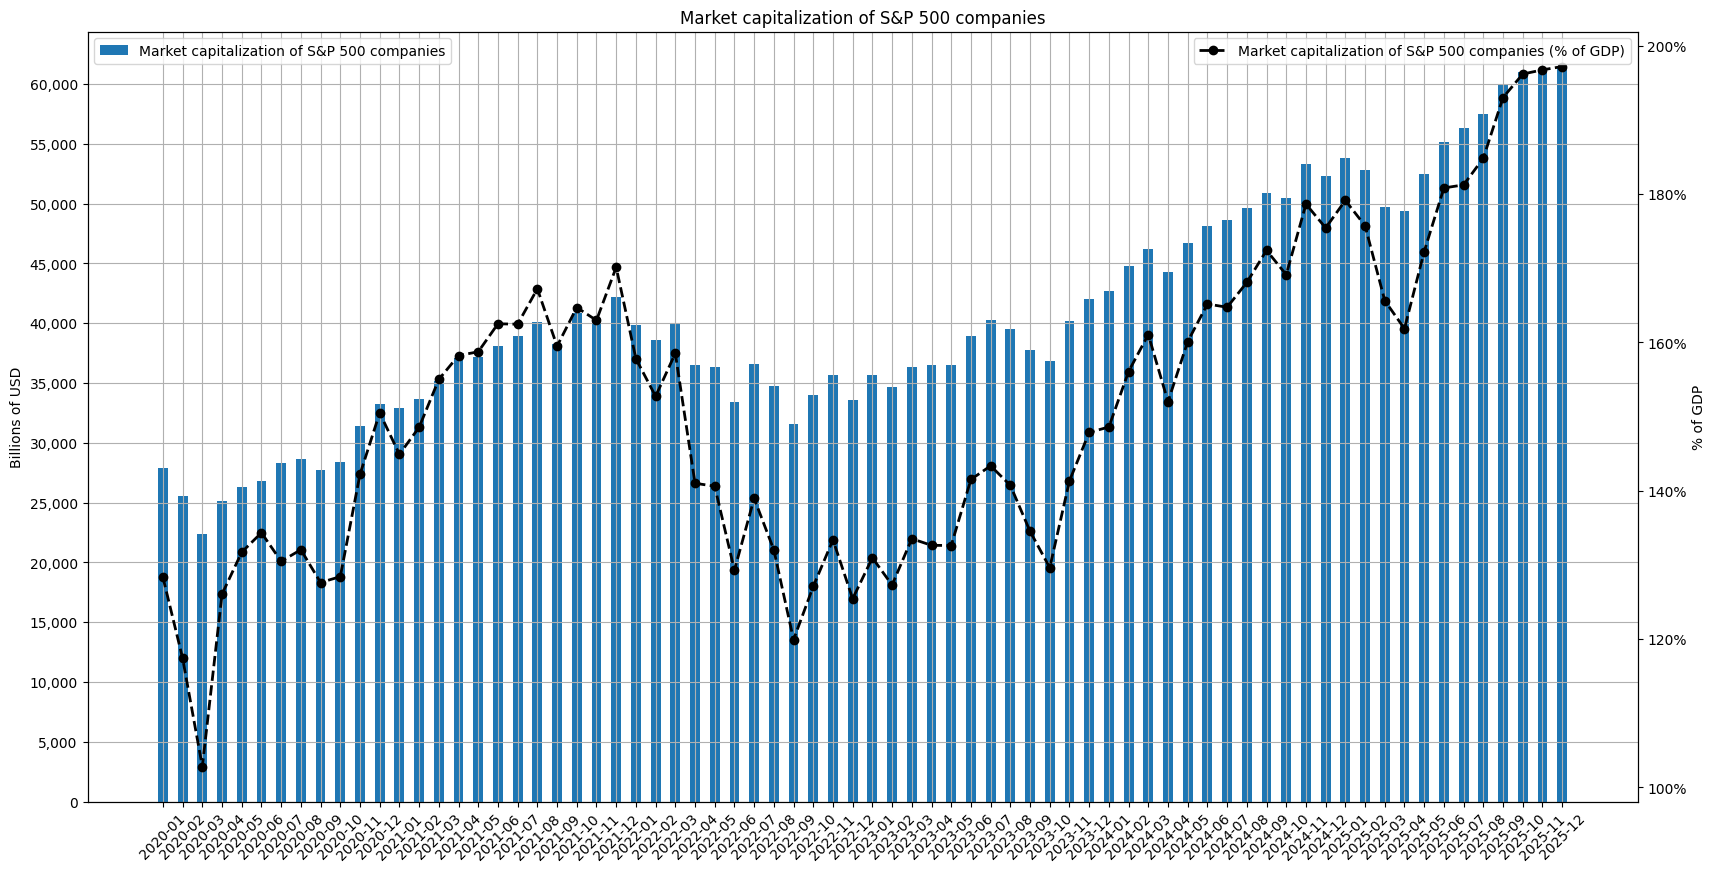

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
y_max = stock_mkt_sp500.iloc[:,0].max()
y_max = y_max + y_max % y_step + 1
ax2 = ax.twinx()
ax.bar(x=range(len(stock_mkt_sp500)), height=stock_mkt_sp500.iloc[:,0], color='#1f77b4',
       width=0.5, label=MKT_CAP_SP500)
ax2.plot(range(len(stock_mkt_sp500)), stock_mkt_sp500.iloc[:,1], color='k', marker='o',
         label=MKT_CAP_SP500_TO_GDP, linestyle='--', linewidth=2)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.title.set_text(MKT_CAP_SP500)
ax.grid(True)
_ = ax.set_xticks(range(len(stock_mkt_sp500)), stock_mkt_sp500.index)
_ = ax.set_xticklabels(stock_mkt_sp500.index.strftime('%Y-%m'), rotation=45)
ax.set_yticks(np.arange(0, y_max, y_step))
ax.set_ylabel(LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax2.set_ylabel(RIGHT_Y_AXIS_LABEL)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))

In [16]:
ts = stock_mkt.index[-1]
print('On {:%Y-%m-%d} market capitalization of the S&P 500 companies comprised {:.2%} of the capitalization of all domestic listed companies'.format(
      ts, sp500_metrics.capitalization.Capitalization.loc[ts] / stock_mkt.loc[ts].iloc[0] / 1e9))

On 2024-12-31 market capitalization of the S&P 500 companies comprised 84.14% of the capitalization of all domestic listed companies


### Top-10 S&P 500 companies by their capitalization and their share in the overall capitalization of S&P 500
It is frequently observed that capitalization of S&P 500 is highly concentrated in its top 6 constituent companies by market capitalization. There's even sometimes talk of S&P 494 where the top 6 companies are excluded. In this part of the notebook I look at the capitalization of the top 10 S&P 500 constituent companies by market capitaliation. **NB:** Since Alphabet Inc is represented in the index twice given its different Class A `GOOGL` and Class C `GOOG` shares, I make an adjustment for it by merging the capitalization of both share classes. If you dont't want that, set the `merge_additional_share_classes` argument of the `get_top_n_capitalization_companies_for_XXX` methods in the cell below to `False`.

Consistently with the rest of the notebook, for periods that are complete, I use end of period capitalization&mdash;e.g. capitalization reported for 2024 is one fro the last trading day of 2024. You can change this behaviour by adjusting the `method` parameter appropriately. Other values possible are `mean`, `first`, `min`, and `max`.

In [17]:
top10_today = sp500_metrics.get_top_n_capitalization_companies_for_day(10, merge_additional_share_classes=True)
top10_last_month = sp500_metrics.get_top_n_capitalization_companies_for_month(
    10, sp500_metrics.data.index[-1] - pd.DateOffset(months=+1), method='last')

# Uncomment if you want to compare the last day of last month
# lbme = pd.offsets.BMonthEnd(0).rollback(sp500_metrics.data.index[-1])
# top10_today = sp500_metrics.get_top_n_capitalization_companies_for_day(10, lbme, merge_additional_share_classes=True)
# top10_last_month = sp500_metrics.get_top_n_capitalization_companies_for_month(
#     10, lbme - pd.DateOffset(months=+1), method='last')

# Calculate metrics for the previous 4 years
num_years = 4
years = list(range(sp500_metrics.data.index[-1].year-num_years, sp500_metrics.data.index[-1].year))
top10_last_n_years = [sp500_metrics.get_top_n_capitalization_companies_for_year(10, date(year, 1, 1), method='last') for year in years]

In [18]:
# Convert into Billions of USD
top10 = list(map(lambda df: df.Capitalization, top10_last_n_years))
top10.append(top10_today.Capitalization)
top10 = pd.concat(top10, axis=1) / 1e9
columns = [sp500_metrics.CAPITALIZATION + f' in {year}' for year in years]
columns.append(' now')
top10.columns = columns

top10_pct = list(map(lambda df: df.iloc[:,1], top10_last_n_years))
top10_pct.append(top10_today.iloc[:,1])
top10_pct = pd.concat(top10_pct, axis=1)

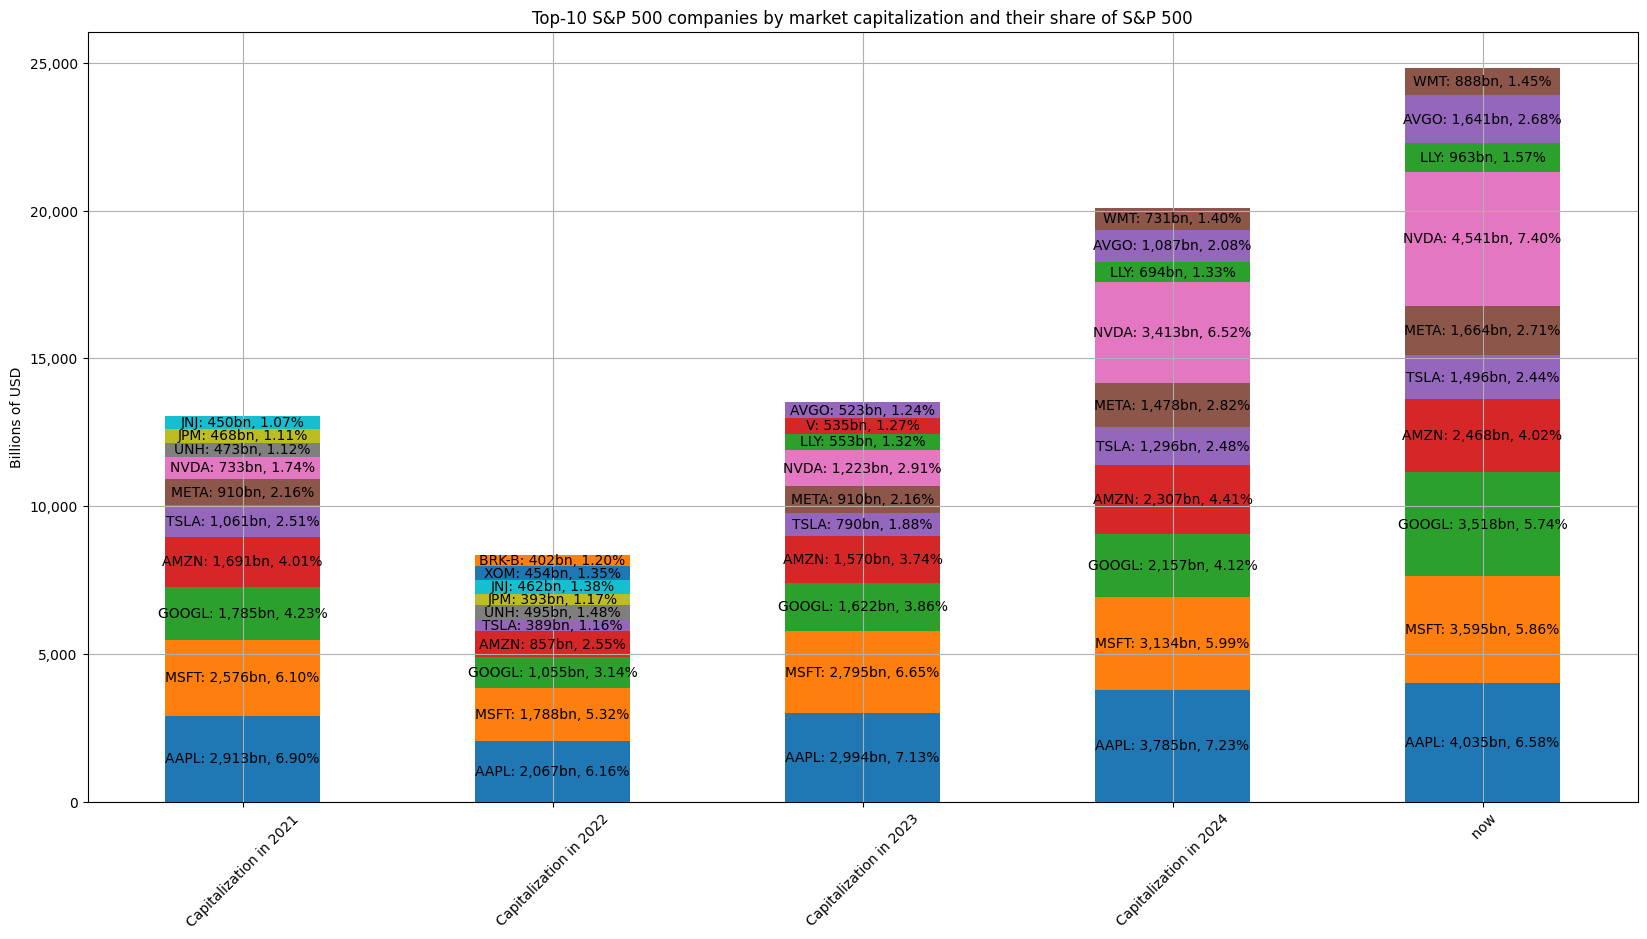

In [19]:
ax = top10.T.plot.bar(figsize=(20,10), grid=True, title=MKT_CAP_TOP10_SP500,
                      stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.get_legend().remove()
for c in ax.containers:
    labels = [c.get_label() + f': {a:,.0f}bn, {top10_pct.loc[c.get_label()].iloc[i]:.2%}'
              if a else '' for i, a in enumerate(c.datavalues)]
    ax.bar_label(c, labels=labels, label_type="center")

In [20]:
top10_now = pd.concat([top10_last_month.Capitalization, top10_today.Capitalization], axis=1) / 1e9
top10_now.columns = [sp500_metrics.CAPITALIZATION + sfx for sfx in [' last month', ' now']]
# Uncomment if you want to compare with the capitalization at the end of the prevous year
# top10_now = pd.concat([top10_last_n_years[-1].Capitalization, top10_today.Capitalization], axis=1) / 1e9
# next_bd = sp500_metrics.data.index[-1] + pd.offsets.BDay(1)
# ye = pd.offsets.YearEnd().rollforward(sp500_metrics.data.index[-1])
# top10_now.columns = [sp500_metrics.CAPITALIZATION + sfx for sfx in [f' YE {sp500_metrics.data.index[-1].year-1}',
#                                                                     ' now' if next_bd < ye else f'YE {sp500_metrics.data.index[-1].year}']]
top10_today_pct = pd.concat([top10_last_month.iloc[:,1], top10_today.iloc[:,1]], axis=1)

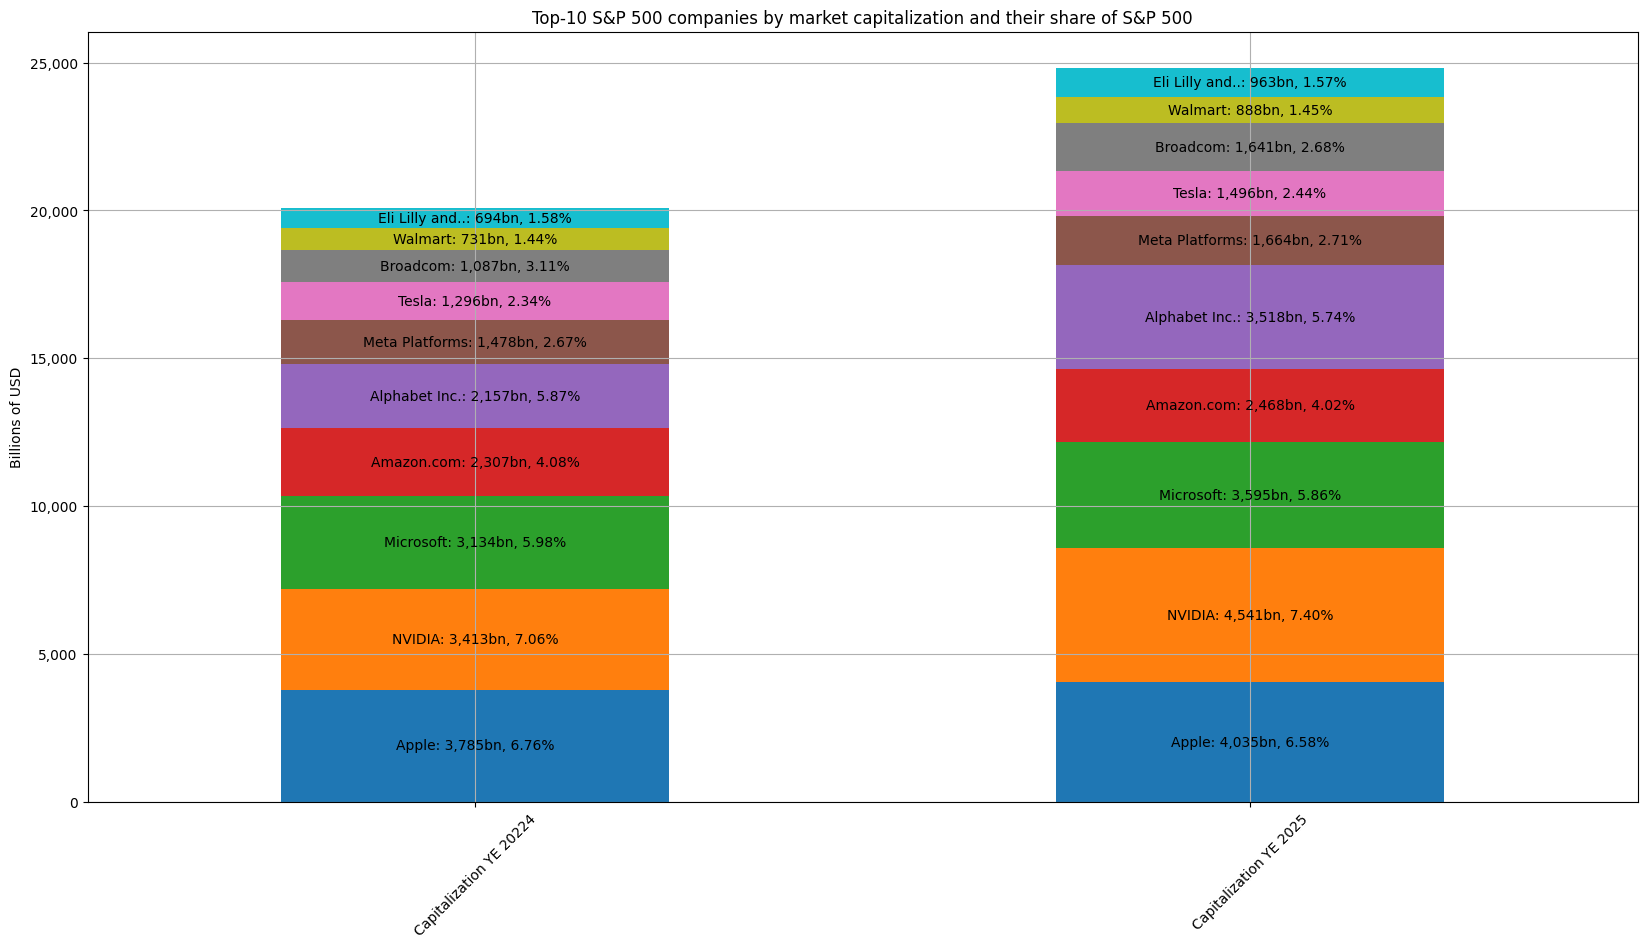

In [21]:
names = sp500_metrics.tickers_to_display_names(top10_now.index)
ticker_to_name = dict(zip(top10_now.index, names))
ax = top10_now.T.plot.bar(figsize=(20,10), grid=True, title=MKT_CAP_TOP10_SP500,
                          stacked=True, rot=45, ylabel=LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax.get_legend().remove()
for c in ax.containers:
    labels = [ticker_to_name[c.get_label()] + f': {a:,.0f}bn, {top10_today_pct.loc[c.get_label()].iloc[i]:.2%}'
              if a else '' for i, a in enumerate(c.datavalues)]
    ax.bar_label(c, labels=labels, label_type="center")

In [22]:
cur_month = sp500_metrics.data.index[-1].month
# In billions of USD
cap_now = sp500_metrics.capitalization.iloc[-1,0] / 1e9
cap_end_last_year = stock_mkt_sp500.iloc[-cur_month-1, 0]
print(f'The capitalization of S&P 500 on {sp500_metrics.capitalization.index[-1]:%Y-%m-%d} is ${cap_now/1e3:.3f}trn')
print(f'It is {cap_now / gdp.iloc[-1]:.2%} of US GDP')

print(f'It changed by ${(cap_now - cap_end_last_year)/1e3:+.3f}trn ({cap_now / cap_end_last_year - 1:+.2%}) '
      f'compared with {stock_mkt_sp500.index[-cur_month-1]:%Y-%m-%d}')
print(f'And its share of GDP changed by {stock_mkt_sp500.iloc[-1,1]-stock_mkt_sp500.iloc[-cur_month-1,1]:+.2%} '
      f'compared with {stock_mkt_sp500.index[-cur_month-1]:%Y-%m-%d}')

The capitalization of S&P 500 on 2025-12-31 is $61.320trn
It is 197.20% of US GDP
It changed by $+8.995trn (+17.19%) compared with 2024-12-31
And its share of GDP changed by +21.76% compared with 2024-12-31


In [23]:
print(f'The Top-10 constituent companies in S&P 500 make up {top10_today.iloc[:,1].sum():.2%} of the index')
print(f'With a cumulative capitalization of ${top10_today.iloc[:,0].sum()/1e12:.3f}trn')
print(f'Their capitalization changed by ${(top10_today.iloc[:,0].sum()-top10_last_month.iloc[:,0].sum())/1e9:+.3f}bn'
      ' compared to a month ago')
print(f'Their capitalization changed by ${(top10_today.iloc[:,0].sum()-top10_last_n_years[-1].Capitalization.sum())/1e9:+.3f}bn'
      f' ({top10_today.iloc[:,0].sum()/top10_last_n_years[-1].Capitalization.sum()-1:.2%}) compared to a year ago')

The Top-10 constituent companies in S&P 500 make up 40.46% of the index
With a cumulative capitalization of $24.807trn
Their capitalization changed by $-204.302bn compared to a month ago
Their capitalization changed by $+4725.229bn (23.53%) compared to a year ago


The Magnificent Seven &mdash; is a term that refers to a group of seven major technology companies:
* Nvidia (NVDA)
* Apple (AAPL)
* Alphabet (GOOGL/GOOG)
* Meta Platforms (META)
* Microsoft (MSFT)
* Amazon (AMZN)
* Tesla (TSLA). However, as of May 2025, Broadcom (AVGO) has jumped into the ranking, while Tesla has dropped out.

In [24]:
MAGN_SEVEN = ['MSFT', 'AAPL', 'META', 'AMZN', 'TSLA', 'NVDA', 'GOOG', 'GOOGL']

In [25]:
magn_seven = sp500_metrics.get_capitalization_for_companies(MAGN_SEVEN + ['AVGO'], 'B')
AVGO_REPLACES_TSLA_DATE = '2025-06-01'
magn_seven.loc[:pd.Timestamp(AVGO_REPLACES_TSLA_DATE) - pd.offsets.BDay(1), 'AVGO'] = 0
magn_seven.loc[AVGO_REPLACES_TSLA_DATE:, 'TSLA'] = 0
magn_seven_cum_cap = magn_seven.iloc[:,1:].sum(axis=1)
print(f'The Magnificent Seven constituent companies in S&P 500 make up '
      f'{magn_seven_cum_cap.iloc[-1]/magn_seven.iloc[-1,0]:.2%} of the index')
print(f'With a cumulative capitalization of ${magn_seven_cum_cap.iloc[-1]/1e12:.3f}trn')

# As of June 2025
MAGN_SEVEN = ['MSFT', 'AAPL', 'META', 'AMZN', 'AVGO', 'NVDA', 'GOOG', 'GOOGL']

The Magnificent Seven constituent companies in S&P 500 make up 35.00% of the index
With a cumulative capitalization of $21.460trn


#### Capitalization development of the magnificent seven stocks since 2020

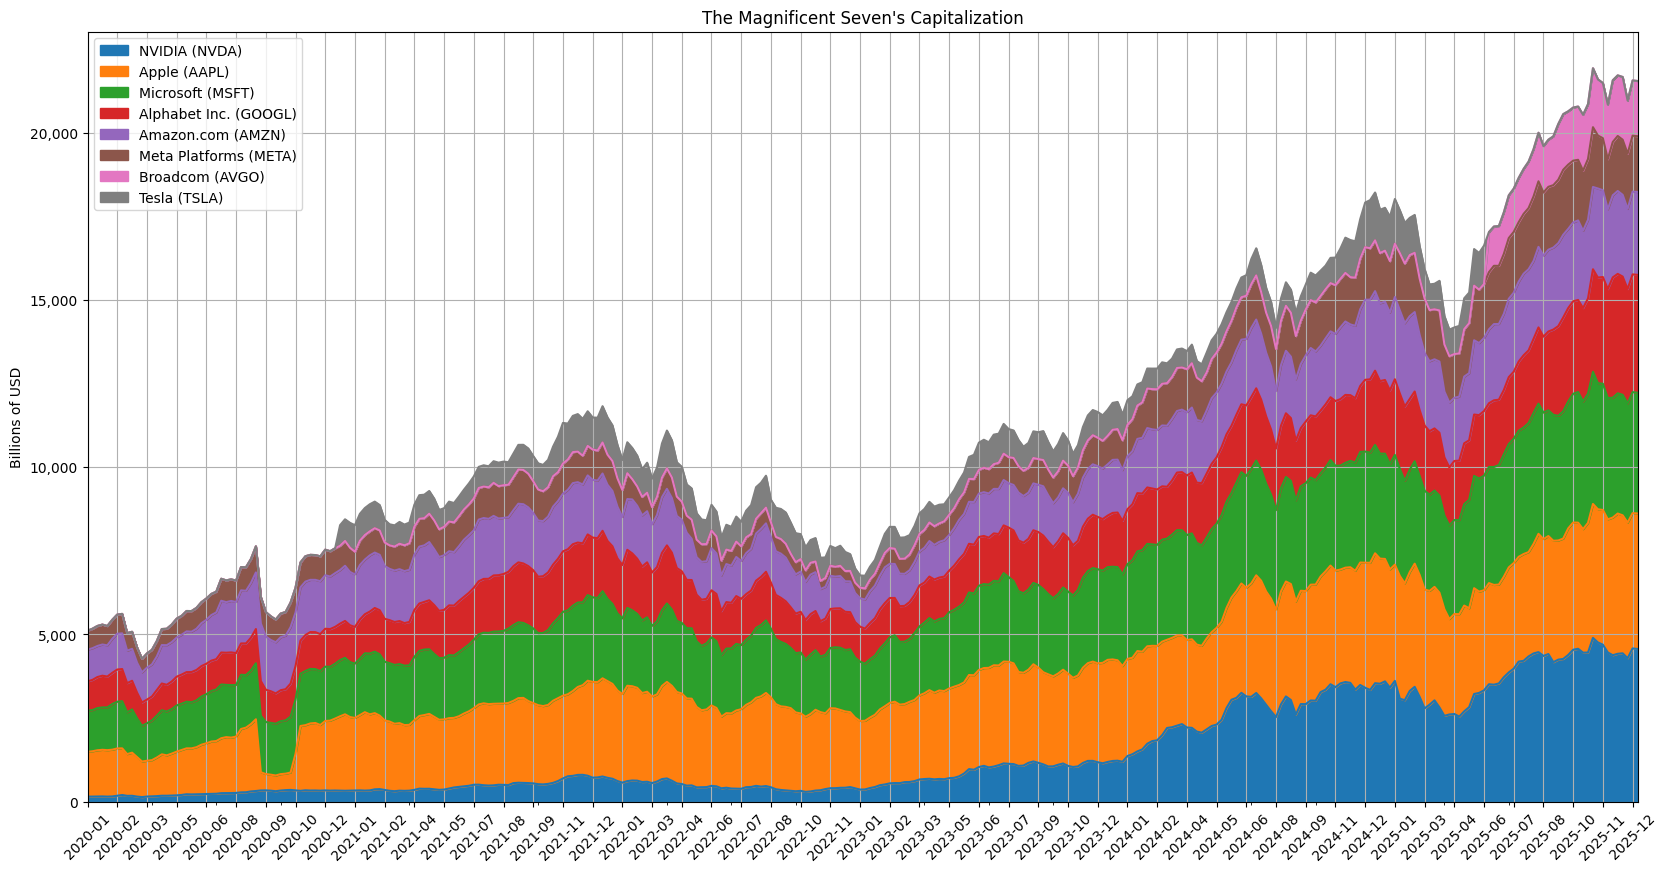

In [26]:
magn_seven_weekly = magn_seven.iloc[:,1:].resample('W').mean() / 1e9
magn_seven_weekly = magn_seven_weekly.loc[:, magn_seven_weekly.iloc[-1].sort_values(ascending=False).index]
ax = magn_seven_weekly.plot.area(figsize=(20,10), grid=True, title="The Magnificent Seven's Capitalization",
                                 xticks=magn_seven_weekly.index[::6], xlabel='', rot=45,
                                 ylabel=LEFT_Y_AXIS_LABEL)
ax.legend(ax.collections, magn_seven_weekly.columns.map(lambda ticker: ticker_to_name[ticker] + f' ({ticker})'))
ax.yaxis.set_major_formatter('{x:,.0f}')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, magn_seven_weekly.index[::6])))

#### Capitalization development of the magnificent seven stocks since last election

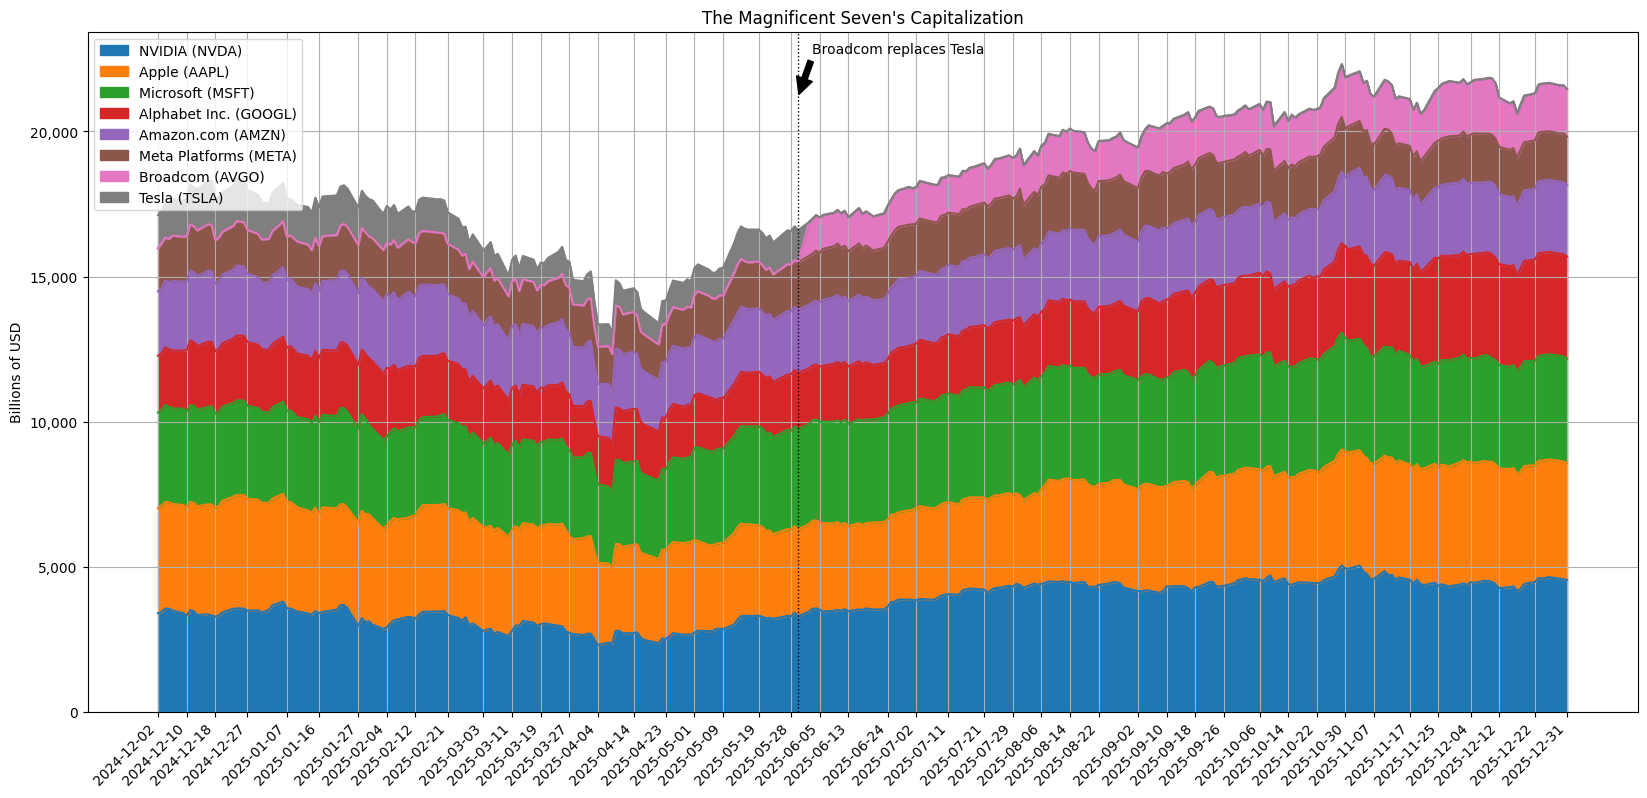

In [27]:
magn_seven_daily = magn_seven.iloc[:,1:] / 1e9
magn_seven_daily = magn_seven_daily.loc[:, magn_seven_daily.iloc[-1].sort_values(ascending=False).index]
magn_seven_daily = magn_seven_daily.loc['2024-12':]
ax = magn_seven_daily.plot.area(figsize=(20,10), grid=True, title="The Magnificent Seven's Capitalization",
                                 xticks=magn_seven_daily.index[::6], xlabel='', rot=45,
                                 ylabel=LEFT_Y_AXIS_LABEL)
nearest_past_date = magn_seven_daily.index.asof(AVGO_REPLACES_TSLA_DATE)
ax.axvline(magn_seven_daily.index[magn_seven_daily.index.get_loc(nearest_past_date)], color='k', linestyle=':', linewidth=1)
y_max = magn_seven_daily.sum(axis=1).max()
y_step = y_max / 15
x1 = magn_seven_daily.index[magn_seven_daily.index.get_loc(nearest_past_date)]
y1 = y_max * .95
x2 = magn_seven_daily.index[magn_seven_daily.index.get_loc(nearest_past_date) + 2]
y2 = y1 + y_step
ax.annotate('Broadcom replaces Tesla',
            xy=(x1, y1), xytext=(x2, y2), horizontalalignment='left',
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.legend(ax.collections, magn_seven_daily.columns.map(lambda ticker: ticker_to_name[ticker] + f' ({ticker})'))
ax.yaxis.set_major_formatter('{x:,.0f}')
_ = ax.set_xticklabels(list(map('{:%Y-%m-%d}'.format, magn_seven_daily.index[::6])))

## Total annual value of stocks traded on US exchanges and its ratio to GDP
In this section of the notebook I look at the total value of domestic and foreign stocks traded on US exchanges in the whole year. The total value is total volume &times; matching prices. If you want to approximate the daily trading value, please divide the annual value by 252, which is an approximation for the number of trading days in the US. All dollar amounts are nominal, i.e. without adjustments for inflation. I also plot the ratio of annual trading volumes to annual GDP.

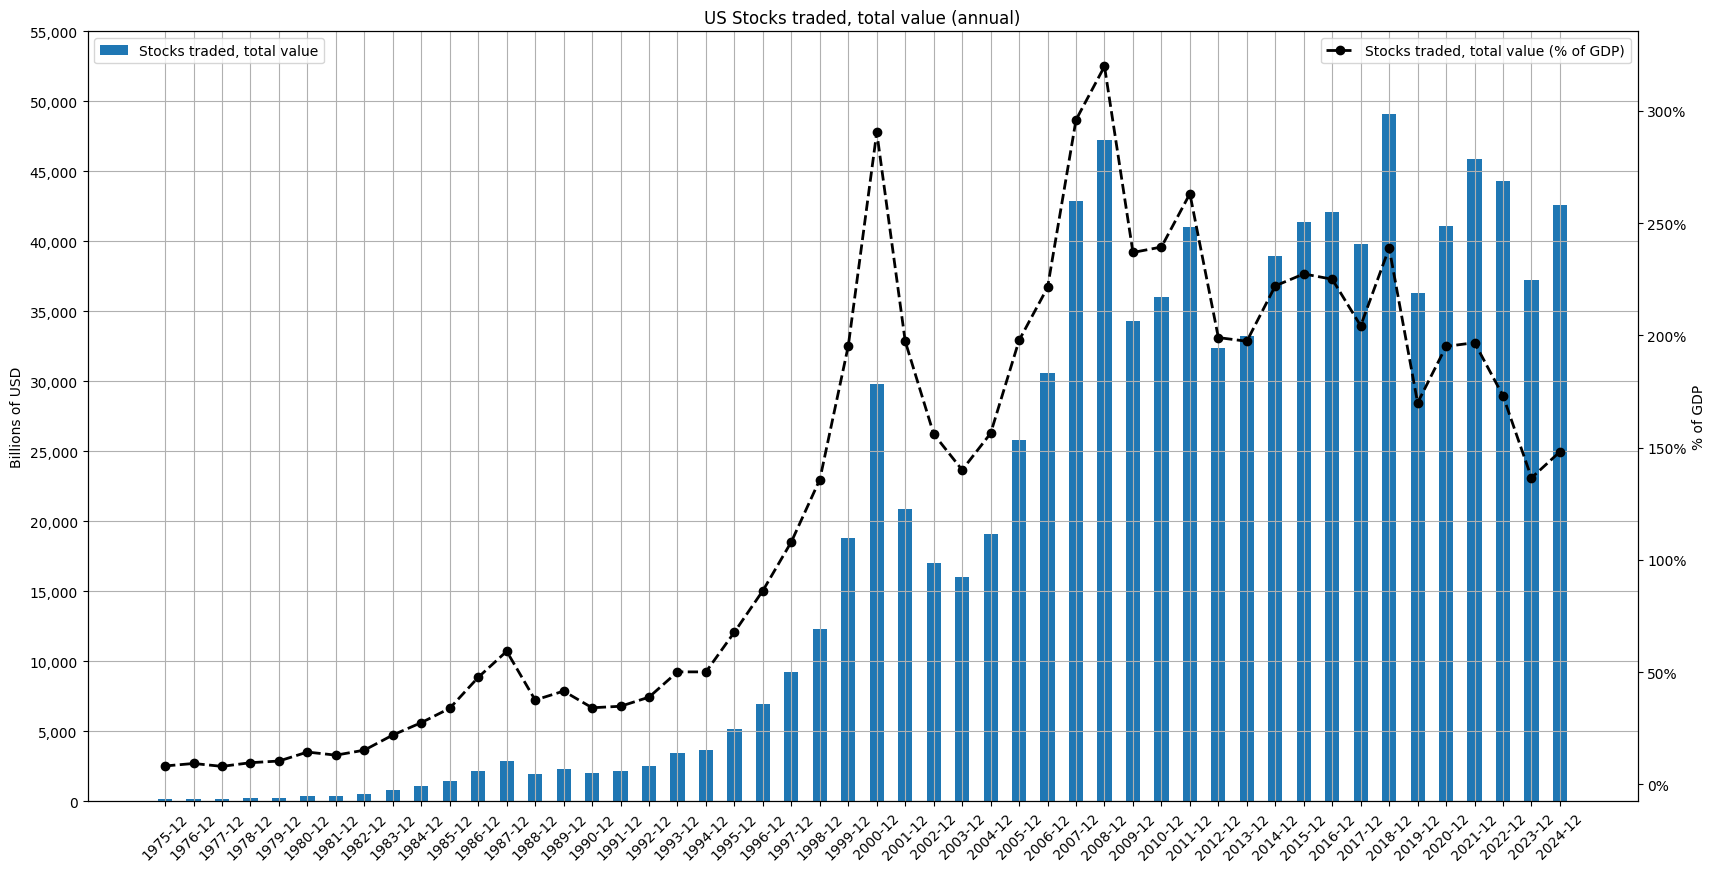

In [28]:
fig, ax = plt.subplots(figsize=(20, 10))
ax2 = ax.twinx()
ax.bar(x=range(len(stock_mkt)), height=stock_mkt.iloc[:,2], color='#1f77b4', width=0.5, label=TRAD_VOL)
ax2.plot(range(len(stock_mkt)), stock_mkt.iloc[:,3], color='k', marker='o', label=TRAD_VOL_TO_GDP,
         linestyle='--', linewidth=2)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.title.set_text(TRAD_VOL_GRAPH_TITLE)
ax.grid(True)
_ = ax.set_xticks(range(len(stock_mkt)), stock_mkt.index)
_ = ax.set_xticklabels(stock_mkt.index.strftime('%Y-%m'), rotation=45)
ax.set_yticks(np.arange(0, 56000, 5000))
ax.set_ylabel(LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax2.set_ylabel(RIGHT_Y_AXIS_LABEL)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))

### Total annual value of S&P 500 stocks traded and its ratio to GDP
For the S&P 500, I present monthly averages of daily trading values. The first graph illustrates the average daily trading volume per month, while the second shows cumulative monthly values scaled to annual totals by multiplying each by 12.

Interestingly, the reported total annual trading value for S&P 500 stocks is higher than that of all US listed companies&mdash;approximately \\$80 trillion for the S&P 500 in 2024, compared to around $42 trillion for the broader market. This apparent paradox arises from differing data sources: the World Bank figures (which I use to provide data on all US listed companies) are based solely on trading volumes from US exchanges, while Yahoo Finance (which I use to provide data on companies that are part of the S&P 500) likely includes off-exchange volumes, such as dark pool and alternative trading system activity, contributing to the higher aggregate.

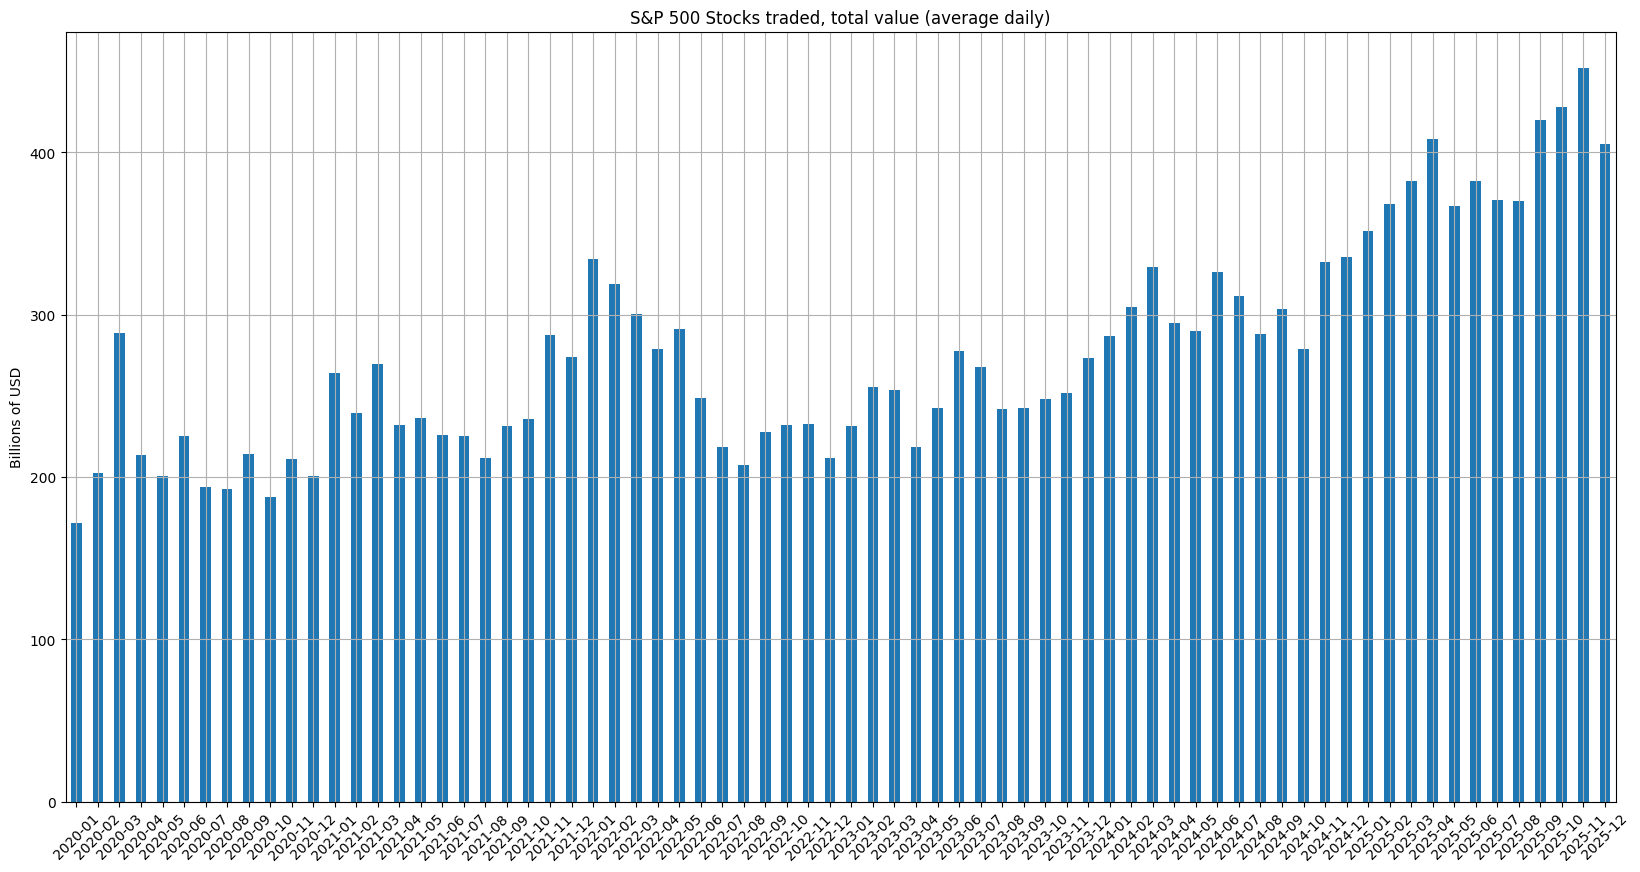

In [29]:
ax = sp500_daily_trading_value.plot.bar(figsize=(20,10), grid=True, ylabel=LEFT_Y_AXIS_LABEL,
                                        title=TRAD_VOL_SP500_GRAPH_TITLE_DAILY, color='#1f77b4',
                                        xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sp500_daily_trading_value.index)))

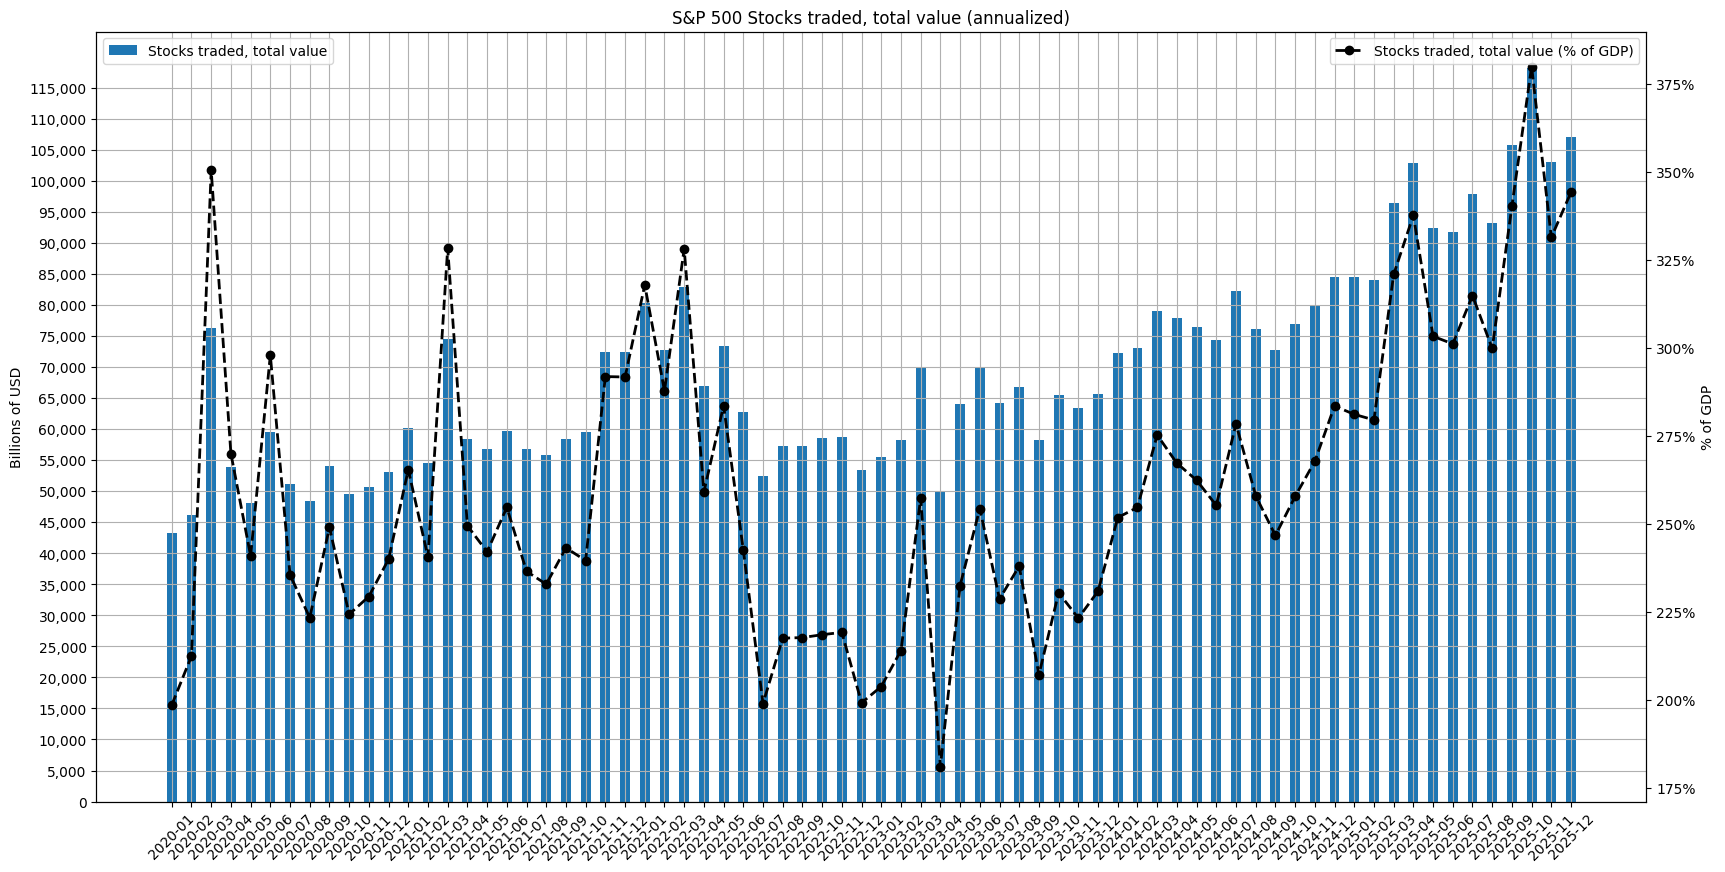

In [30]:
fig, ax = plt.subplots(figsize=(20, 10))
ax2 = ax.twinx()
ax.bar(x=range(len(stock_mkt_sp500)), height=stock_mkt_sp500.iloc[:,2], color='#1f77b4', width=0.5, label=TRAD_VOL)
ax2.plot(range(len(stock_mkt_sp500)), stock_mkt_sp500.iloc[:,3], color='k', marker='o', label=TRAD_VOL_TO_GDP,
         linestyle='--', linewidth=2)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.title.set_text(TRAD_VOL_SP500_GRAPH_TITLE)
ax.grid(True)
_ = ax.set_xticks(range(len(stock_mkt_sp500)), stock_mkt_sp500.index)
_ = ax.set_xticklabels(stock_mkt_sp500.index.strftime('%Y-%m'), rotation=45)
ax.set_yticks(np.arange(0, stock_mkt_sp500.iloc[:,2].max(), 5000))
ax.set_ylabel(LEFT_Y_AXIS_LABEL)
ax.yaxis.set_major_formatter('{x:,.0f}')
ax2.set_ylabel(RIGHT_Y_AXIS_LABEL)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1))

## Stocks traded, annual turnover ratio of domestic shares to capitalization
In this section of the notebook I look at the turnover ratio of domestic shares traded divided by their market capitalization. The value is annualized by multiplying the monthly average by 12. Unfortunately the World Bank doesn't contain newer datum than 2017 and earlier datum than 1994. According to Peter Lynch, in the early 1960s the annual turnover rate in US stocks was 12%, it grew to about 75% in the 1970s.

The graph depicts the total domestic value of share trading of American Stock Exchange, New York Stock Exchange, NASDAQ Stock Market and BATS Global Markets divided by the total domestic market capitalization of American Stock Exchange, New York Stock Exchange and NASDAQ Stock Market.

If you divide the number for a given year by 252 (the approximate number of trading days in the US), you obtain the percentage of domestic listed shares that are traded in one day. This ranges between 0.2% and 1.7%. And such a small fraction of traded shares determines the capitalization of the whole firm.

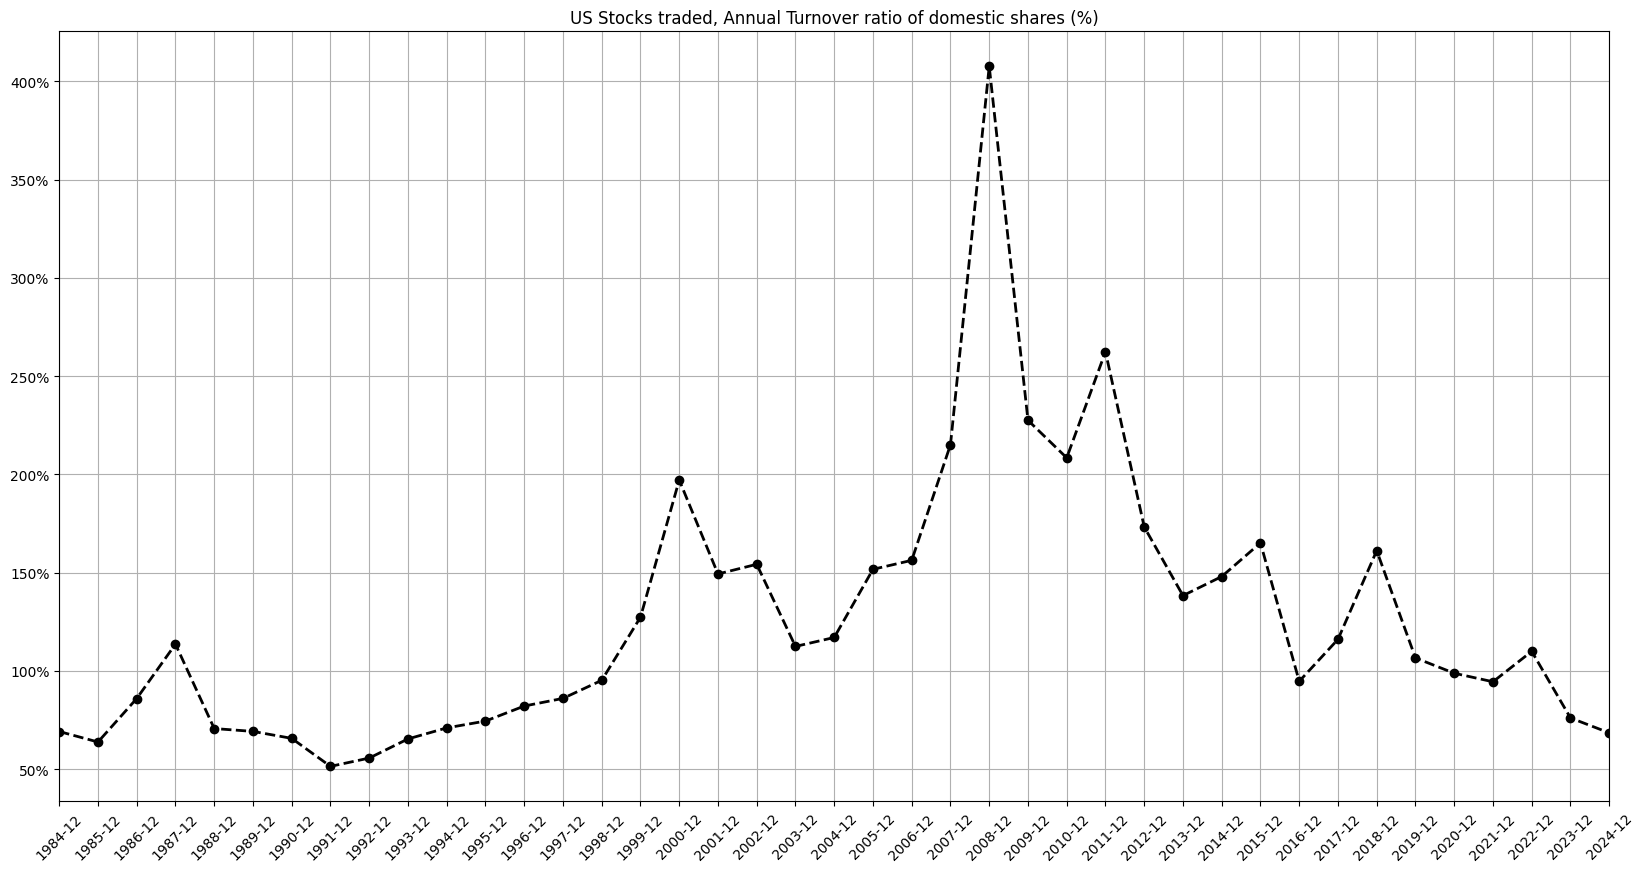

In [31]:
turnover_ratio = stock_mkt.iloc[:,4].dropna()
ax = turnover_ratio.dropna().plot(figsize=(20,10), grid=True,
                                  title=TUROVER_RATIO_GRAPH_TITLE, color='k', marker='o', linestyle='--', linewidth=2,
                                  xticks=turnover_ratio.index, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, turnover_ratio.index)))

In [32]:
print('Approximately between {:.2%} and {:.2%} of domestic shares are traded daily on US exchanges'.format(
    turnover_ratio.min() / 252, turnover_ratio.max() / 252))

Approximately between 0.20% and 1.62% of domestic shares are traded daily on US exchanges


### Stocks traded, annual and daily turnover ratio of S&P 500 shares to capitalization

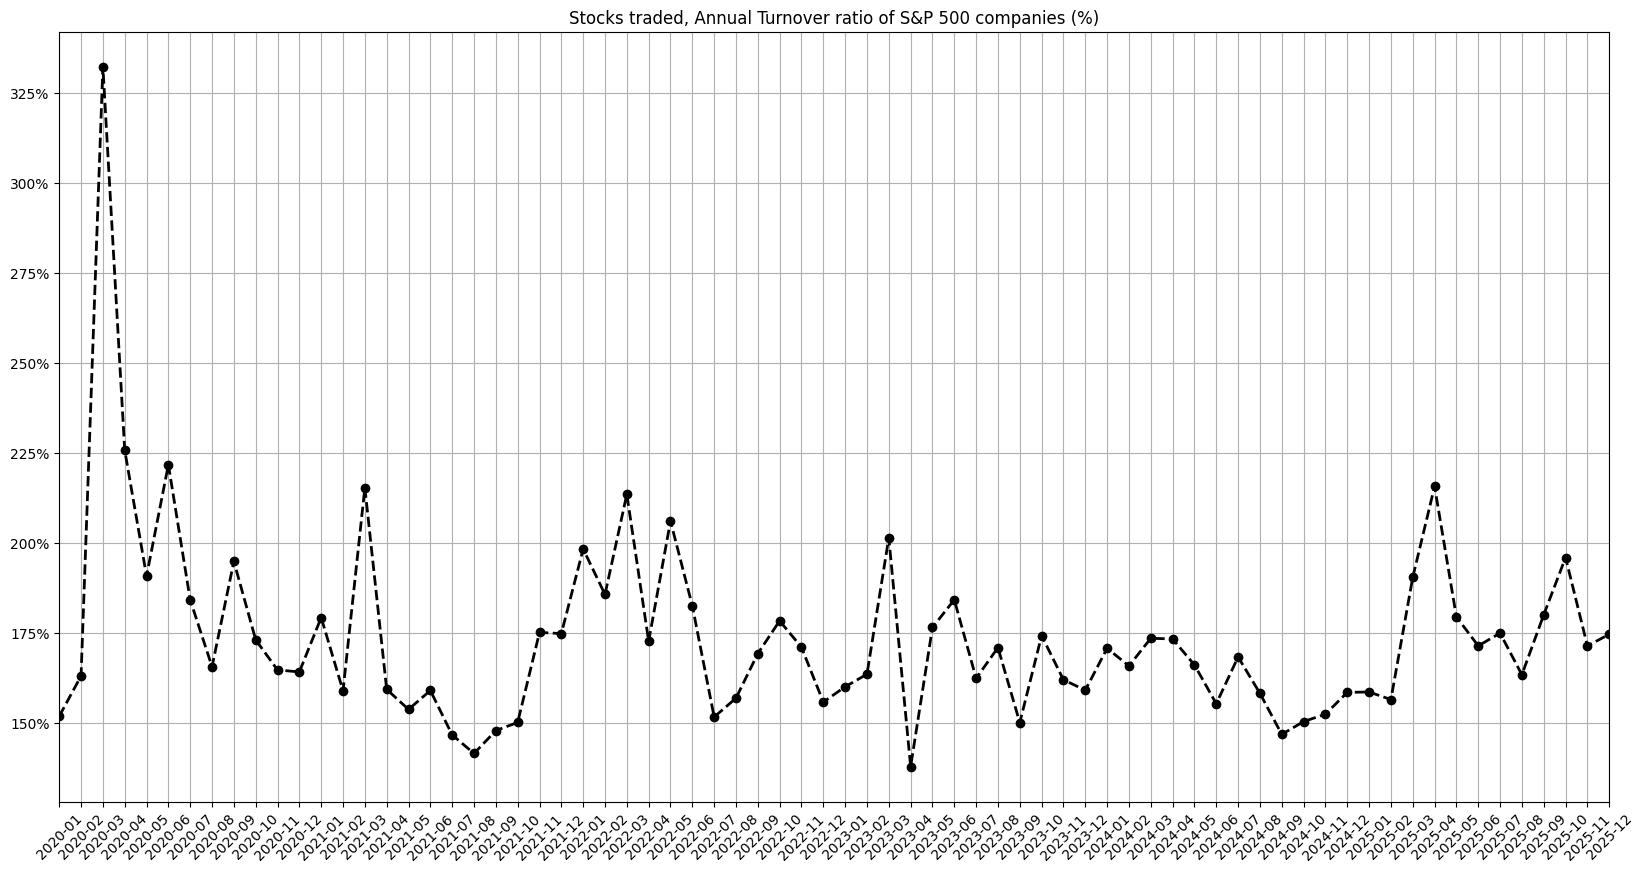

In [33]:
ax = sp500_annual_turnover.plot(figsize=(20,10), grid=True,
                                title=TUROVER_RATIO_SP500_GRAPH_TITLE, color='k', marker='o', linestyle='--',
                                linewidth=2, xticks=sp500_annual_turnover.index, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sp500_annual_turnover.index)))

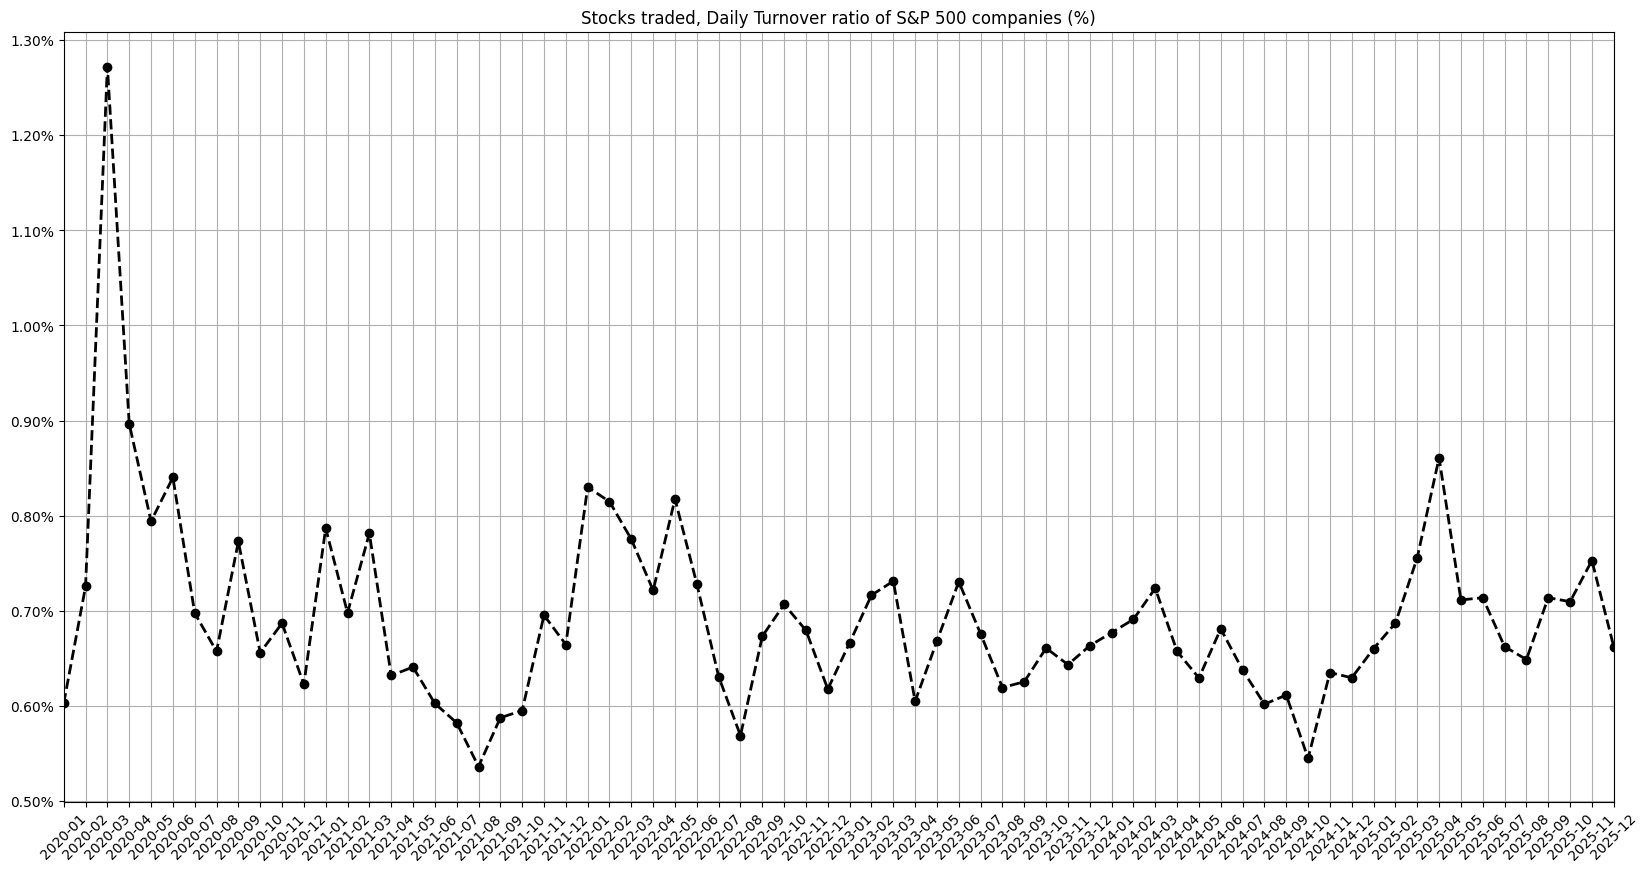

In [34]:
ax = sp500_daily_turnover.plot(figsize=(20,10), grid=True,
                               title=TUROVER_RATIO_SP500_DAILY_GRAPH_TITLE, color='k', marker='o', linestyle='--',
                               linewidth=2, xticks=sp500_daily_turnover.index, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sp500_daily_turnover.index)))

## Total number of listed domestic companies
In this section of the notebook I look at the total number of listed domestic US companies, including foreign companies which are exclusively listed in the US. Counted are those companies which have shares listed on a US exchange at the end of the year. Investment funds, unit trusts, and companies whose only business goal is to hold shares of other listed companies, such as holding companies and investment companies, regardless of their legal status, are excluded. A company with several classes of shares is counted once. Only companies admitted to listing on US exchanges are included.

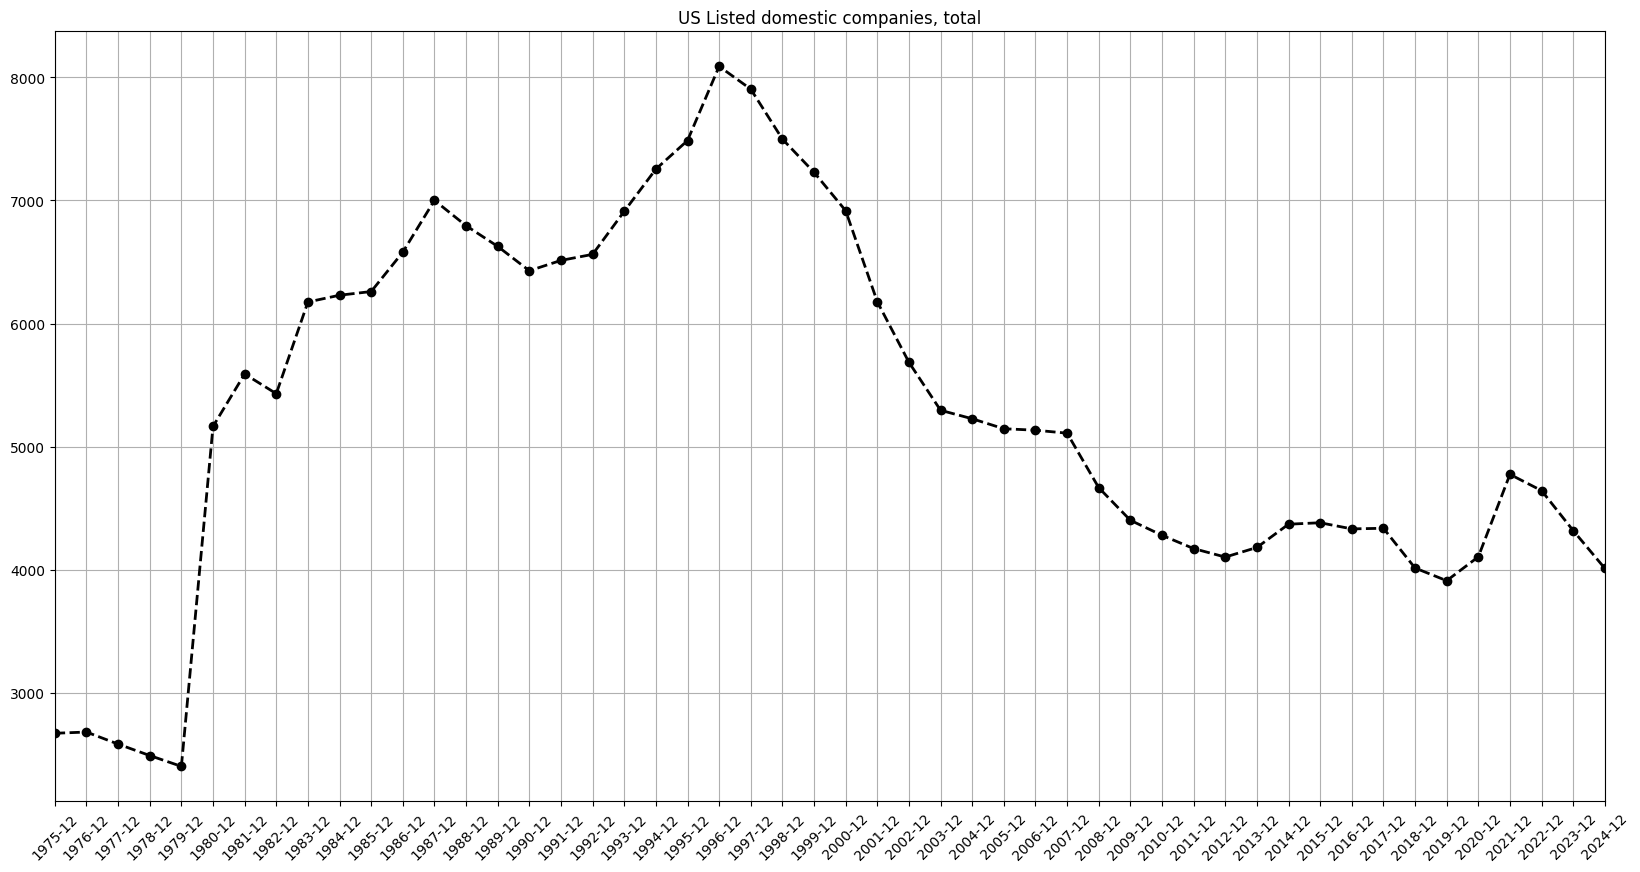

In [35]:
num_domestic_listed = stock_mkt.iloc[:,5].dropna()
ax = num_domestic_listed.dropna().plot(figsize=(20,10), grid=True,
                                       title=NUM_LISTED_DOMESTIC_GRAPH_TITLE, color='k', marker='o', linestyle='--',
                                        linewidth=2, xticks=num_domestic_listed.index, xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, num_domestic_listed.index)))

## Volatility of a subset of US Stock Market represented by S&P 500 companies
In this section of the notebook I look at the annual volatility of the subset of the US Stock Market represented by companies that are part of the S&P 500 index. I use an exponentially weighted moving average approach to calculate historical  volatility with a &lambda; = 0.94453. 

I also depict the volatility implied for S&P500 by [the VIX index](https://en.wikipedia.org/wiki/VIX) for next month. If you don't want to see it, please set the `use_VIX_implied_volatility` variable in Cell 1 to `False`.

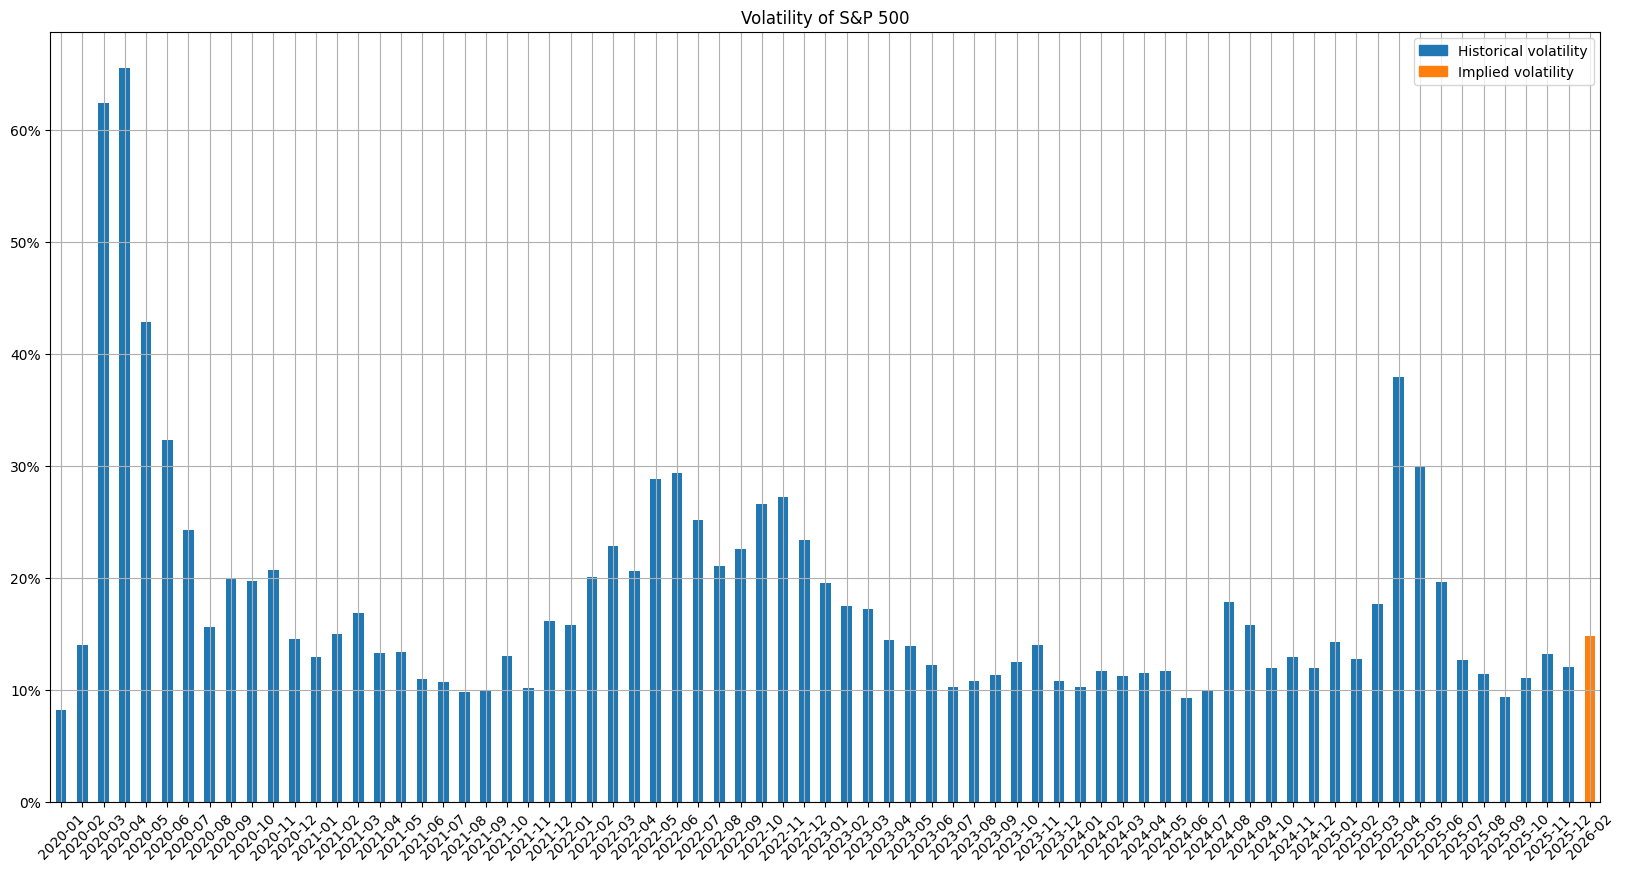

In [36]:
import matplotlib.patches as mpatches
colors = ['#1f77b4']*(len(sp500_volatility)-1) + ['#ff7f0e'] if use_VIX_implied_volatility else None
ax = sp500_volatility.plot.bar(figsize=(20,10), grid=True, title=VOLATILITY_SP500, xlabel='', rot=45, color=colors)
if use_VIX_implied_volatility:
    ax.legend(handles=[mpatches.Patch(color='#1f77b4', label='Historical volatility'),
                       mpatches.Patch(color='#ff7f0e', label='Implied volatility')])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sp500_volatility.index)))

## Excess return of a subset of the US Stock Market represented by S&P 500 companies over riskless rate
In this section of the notebook I look at the excess annual return of S&P 500 over 1-year riskless annual rate implied by Market Yield on U.S. Treasury Securities at 1-Year constant maturity.

$${Excess Return}_{S\&P500} = {R_{S\&P500} - R_{riskless}}$$
where:
* $R_{S\&P500}$ &mdash; annual return on S&P500
* $R_{riskless}$ &mdash; riskless annual return (e.g. as given by Market Yield on U.S. Treasury Securities at 1-Year)

In [37]:
sp500_excess_return = sp500_metrics.get_excess_return(years=2, frequency='MS')

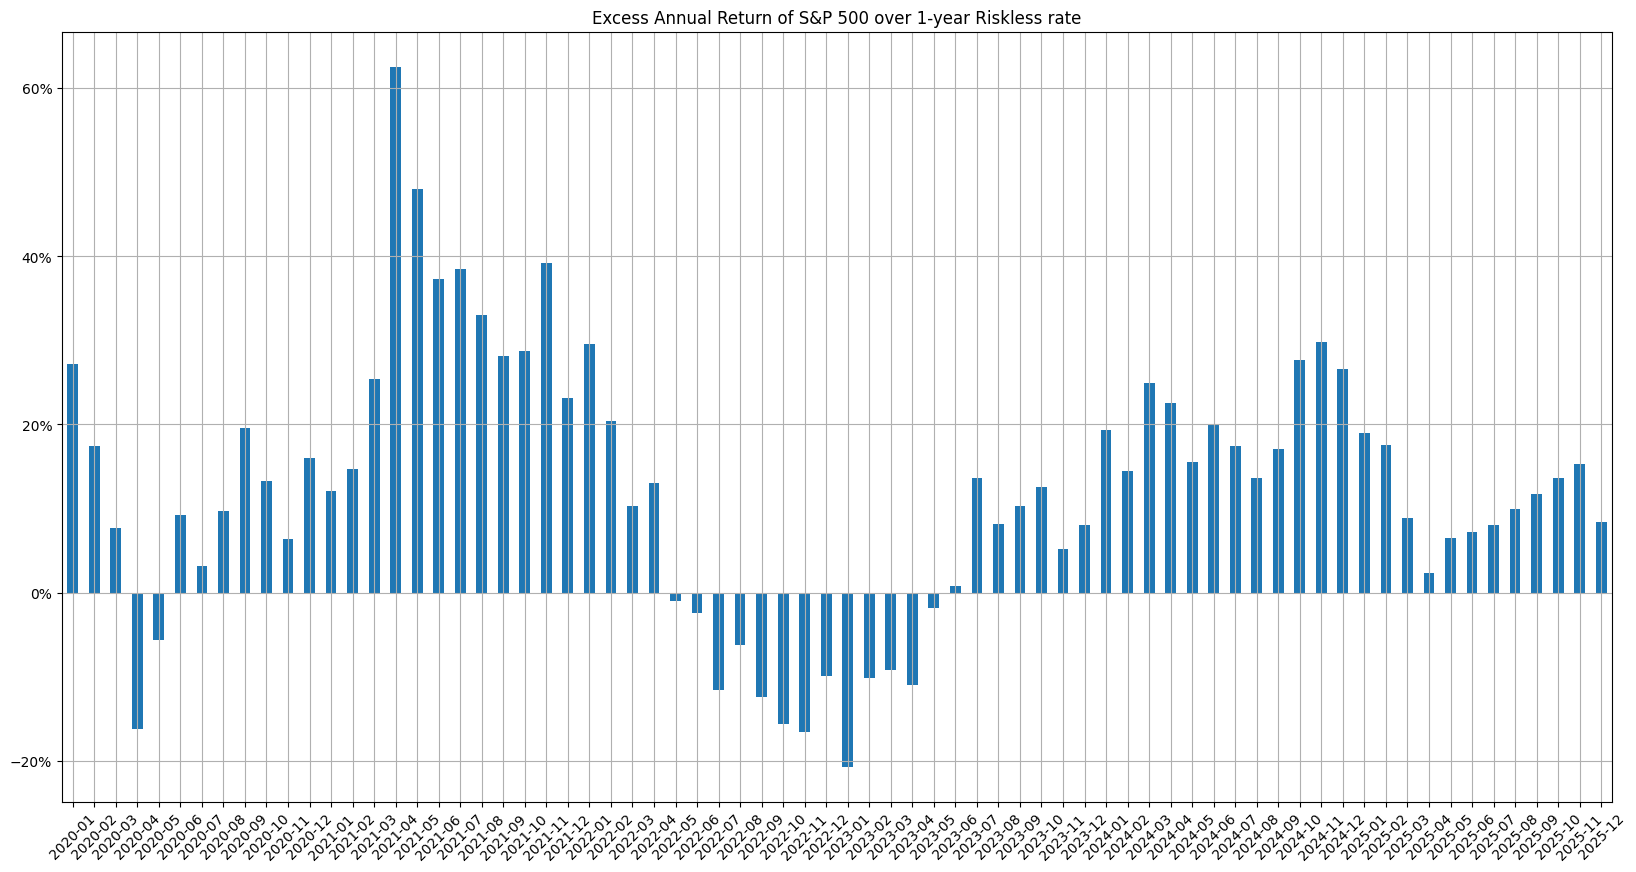

In [38]:
ax = sp500_excess_return.plot.bar(figsize=(20,10), grid=True, title=EXCESS_RETURN_SP500, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sp500_excess_return.index)))

## The Sharpe ratio of a subset of the US Stock Market represented by S&P 500 companies
In this section of the notebook I look at the ex-post Sharpe ratio of S&P 500. It is a measure of the performance of an investment in S&P 500 compared to a risk-free asset, after adjusting for its risk.

$$S_{S\&P500} = \frac{R_{S\&P500} - R_{riskless}}{\sigma_{S\&P500}}$$
where:
* $R_{S\&P500}$ &mdash; annual return on S&P500
* $R_{riskless}$ &mdash; riskless annual return (e.g. as given by Market Yield on U.S. Treasury Securities at 1-Year)
* $\sigma_{S\&P500}$ &mdash; volatility of S&P500

In [39]:
sp500_sharpe_ratio = sp500_metrics.get_sharpe_ratio(years=2, frequency='MS')

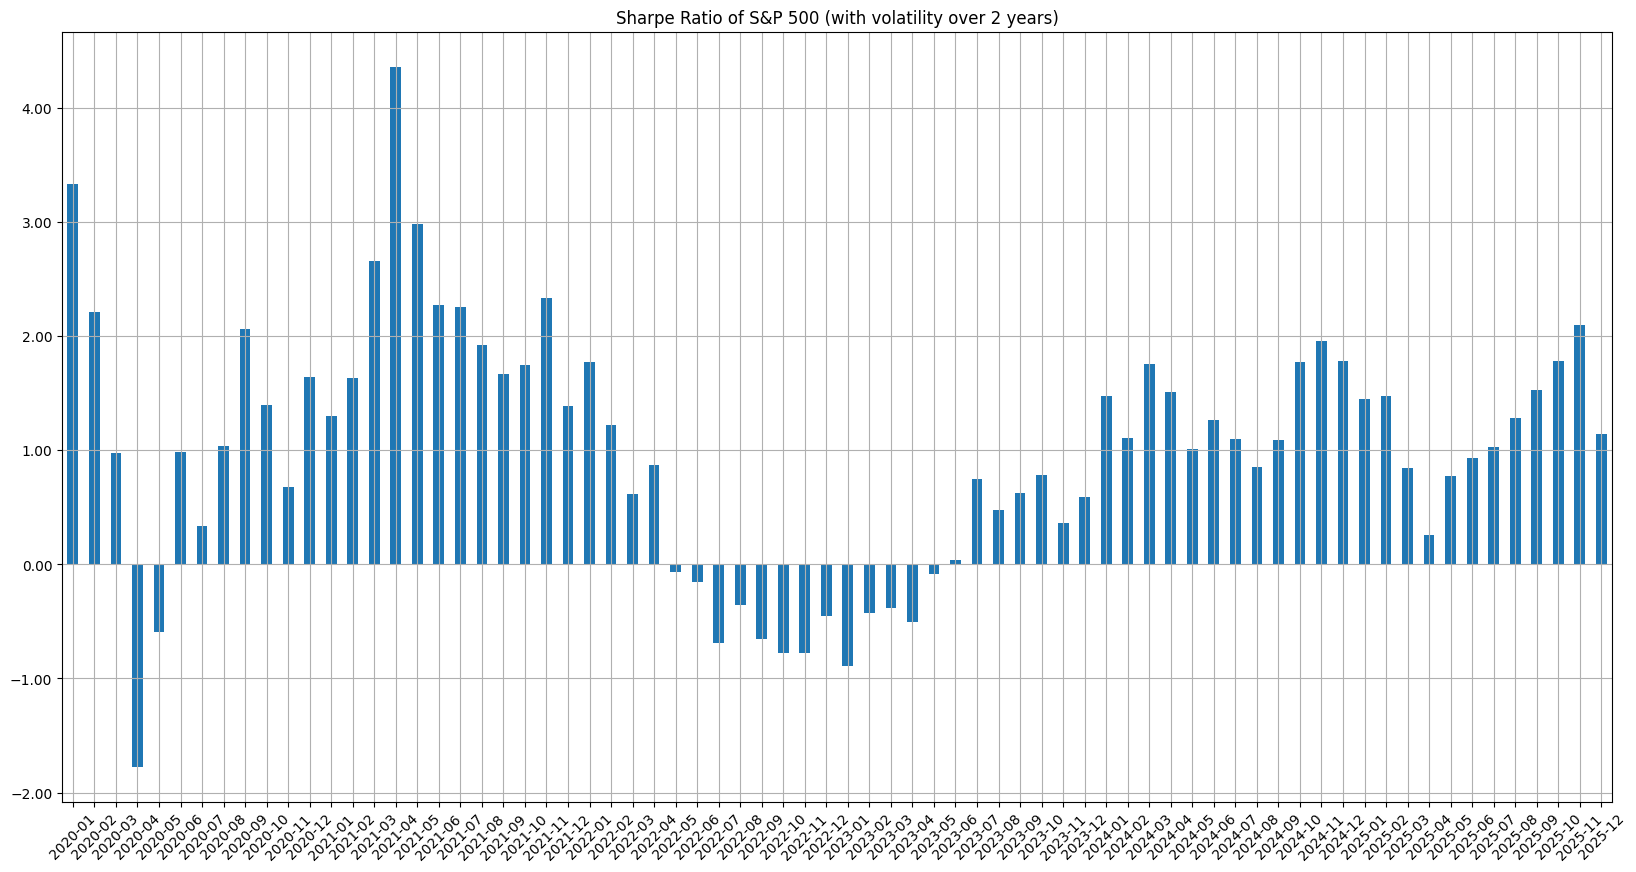

In [40]:
ax = sp500_sharpe_ratio.plot.bar(figsize=(20,10), grid=True,
                                 title=SHARPE_RATIO_SP500.format(2), xlabel='', rot=45)
ax.yaxis.set_major_formatter('{x:.2f}')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, sp500_sharpe_ratio.index)))

## Forward annual dividend yield of a subset of the US Stock Market represented by S&P 500 companies

In [41]:
print(f'S&P 500 forward dividend yield on {sp500_metrics.data.index[-1]:%Y-%m-%d} is '
      f'{sp500_metrics.forward_dividend_yield:.5f}%')

S&P 500 forward dividend yield on 2025-12-31 is 1.16109%


## Forward Price to Earnings ratio of a subset of the US Stock Market represented by S&P 500 companies

In [42]:
print(f'S&P 500 forward P/E on {sp500_metrics.data.index[-1]:%Y-%m-%d} is '
      f'{sp500_metrics.forward_PE:.2f}')

S&P 500 forward P/E on 2025-12-31 is 21.74


## The Capital Asset Pricing Model's &beta; for the Magnificent Seven
Let's calculate how risky owing a porfolio made up of the magnificent seven stocks relative to the whole market
represented by the S&P 500 is, assuming an equal allocation of funds to each of the seven. Since Alphabet has two different classes of shares, I specify 8 ticker symbols and give the two of Alphabet a combined 1/7 share.

In [43]:
beta_ptfl = sp500_metrics.get_beta(MAGN_SEVEN, weights=[1/7]*6 + [1/14] * 2, use_adjusted_close=True)
print(f'\u03B2 of the magnificent seven relative to S&P 500 on {sp500_metrics.data.index[-1]:%Y-%m-%d} is '
      f'{beta_ptfl:.2f}')

[*********************100%***********************]  8 of 8 completed


β of the magnificent seven relative to S&P 500 on 2025-12-31 is 1.42


Now, let's calculate their &beta; , assigning each stock a weight proportional to its capitalization on the most recent trading day, relative to the total capitalization of the Magnificent Seven stocks on the last trading day.

In [44]:
magn_seven_cap = sp500_metrics.get_capitalization_for_companies(MAGN_SEVEN, 'B', merge_additional_share_classes=False).iloc[:, 1:]
magn_seven_total_cap = magn_seven_cap.sum(axis=1)
weights = magn_seven_cap.iloc[-1] / magn_seven_total_cap.iloc[-1]
beta_ptfl = sp500_metrics.get_beta(MAGN_SEVEN, weights, use_adjusted_close=True)
print(f'\u03B2 of the magnificent seven relative to S&P 500 on {sp500_metrics.data.index[-1]:%Y-%m-%d} is '
      f'{beta_ptfl:.2f}')

[*********************100%***********************]  8 of 8 completed

β of the magnificent seven relative to S&P 500 on 2025-12-31 is 1.48


It appears that assigning greater weight to the Magnificent Seven stocks with larger capitalizations doesn't have an effect on the overall risk of the portfolio consisting of the Magnificent Seven stocks.

## A sector breakdown for S&P 500
Understanding the sector breakdown of the S&P 500 is key for investors, as it sheds light on the market’s exposure to different industries. Let’s examine the the current sector breakdown, based on the relative market capitalization of companies within each sector. Notably, the technology sector dominates with 33.71% of the total capitalization, as shown in the below chart.

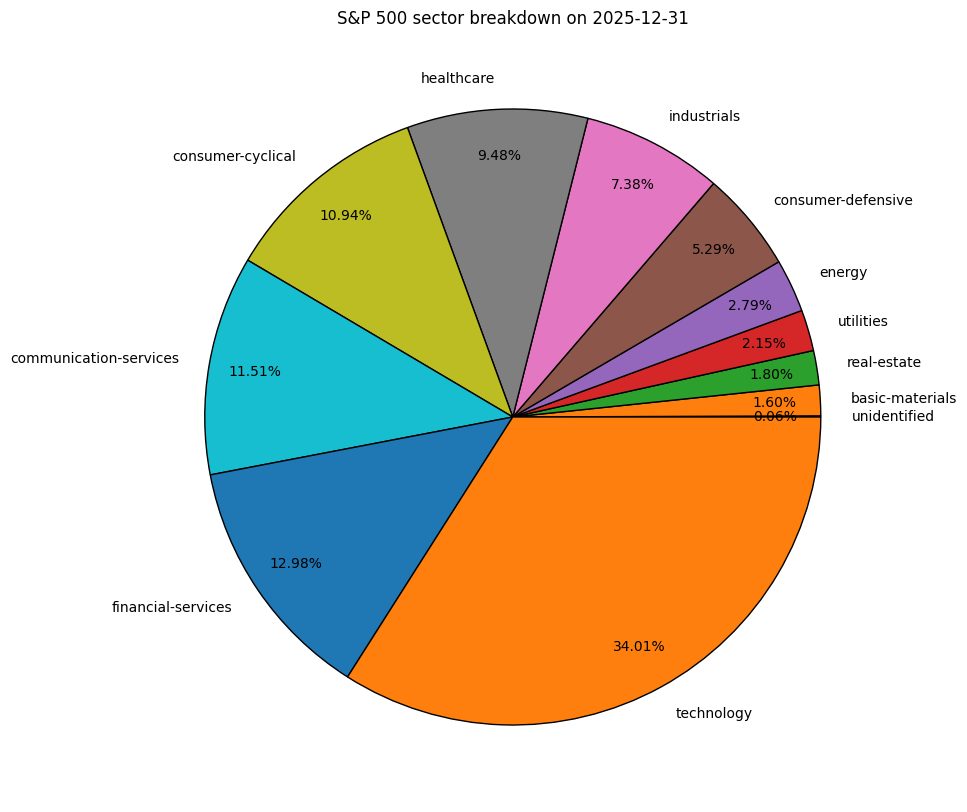

In [45]:
sector_bd = sp500_metrics.get_sector_breakdown_for_day().sort_values()
ax = sector_bd.plot.pie(
    figsize=(20,10), grid=True, ylabel='',
    autopct=lambda pct: f'{pct:.2f}%', pctdistance=0.85,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1},
    title=f'S&P 500 sector breakdown on {sp500_metrics.data.index[-1]:%Y-%m-%d}')

## Year to Date (YTD) changes in capitalization for companies in the S&P 500 index

In [81]:
cap = sp500_metrics.get_capitalization_for_companies(sp500_metrics.get_current_components(), method='last')
cap_now = cap.iloc[-1]
cap_end_last_year = cap.iloc[-cur_month-1]
cap_df = (pd.concat([cap_end_last_year, cap_now], axis=1) / 1e9).dropna()
next_bd = sp500_metrics.data.index[-1] + pd.offsets.BDay(1)
ye = pd.offsets.YearEnd().rollforward(sp500_metrics.data.index[-1])
cap_df.columns = [sp500_metrics.CAPITALIZATION + sfx for sfx in [f' YE {cap.index[-cur_month-1].year}',
                                                                 f' YE {cap.index[-1].year}' if ye < next_bd else ' now']]
TITLE_PFX = f' YE {cap.index[-cur_month-1].year} to ' + (f'YE {cap.index[-1].year}' if ye < next_bd  else ' now')

# Limiting to top and down cut_off companies
cut_off = 40

In [82]:
cap_chg = cap_df.iloc[1:].pct_change(axis=1, fill_method=None).iloc[:, 1].sort_values()
cap_chg

FISV   -71.21%
ARE    -50.39%
DECK   -50.16%
IT     -48.87%
DD     -47.15%
         ...  
NEM    158.84%
WBD    175.46%
WDC    186.46%
STX    228.64%
MU     242.58%
Name: Capitalization YE 2025, Length: 482, dtype: float64

In [68]:
names = sp500_metrics.tickers_to_display_names(sp500_metrics.get_current_components())
ticker_to_name = dict(zip(sp500_metrics.get_current_components(), names))

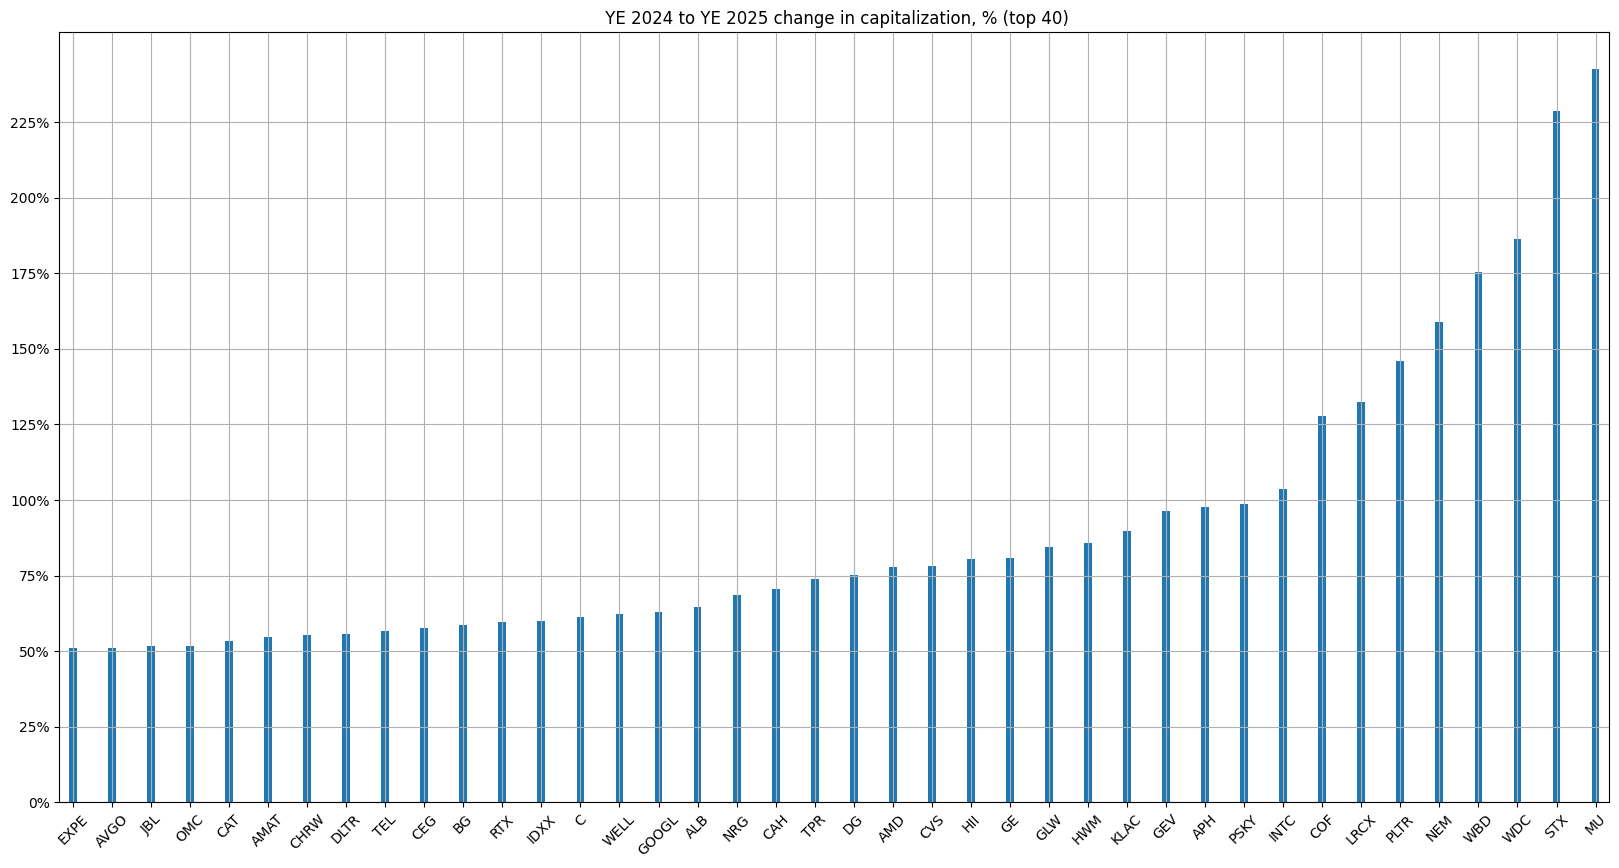

In [83]:
y_max = cap_chg.iloc[-cut_off:].max()
y_step = .25
y_max += y_step - y_max % y_step
ax = cap_chg.iloc[-cut_off:].plot.bar(figsize=(20,10), grid=True, rot=45, width=0.2, yticks=np.arange(0, y_max, y_step),
                                      title=TITLE_PFX + f' change in capitalization, % (top {cut_off})')
# Please uncomment if you want full names rather than ticker names
# ax.set_xticklabels([ticker_to_name[ticker] for ticker in cap_chg.iloc[-cut_off:].index], rotation=45, ha='right')
ax.yaxis.set_major_formatter('{x:,.0%}')

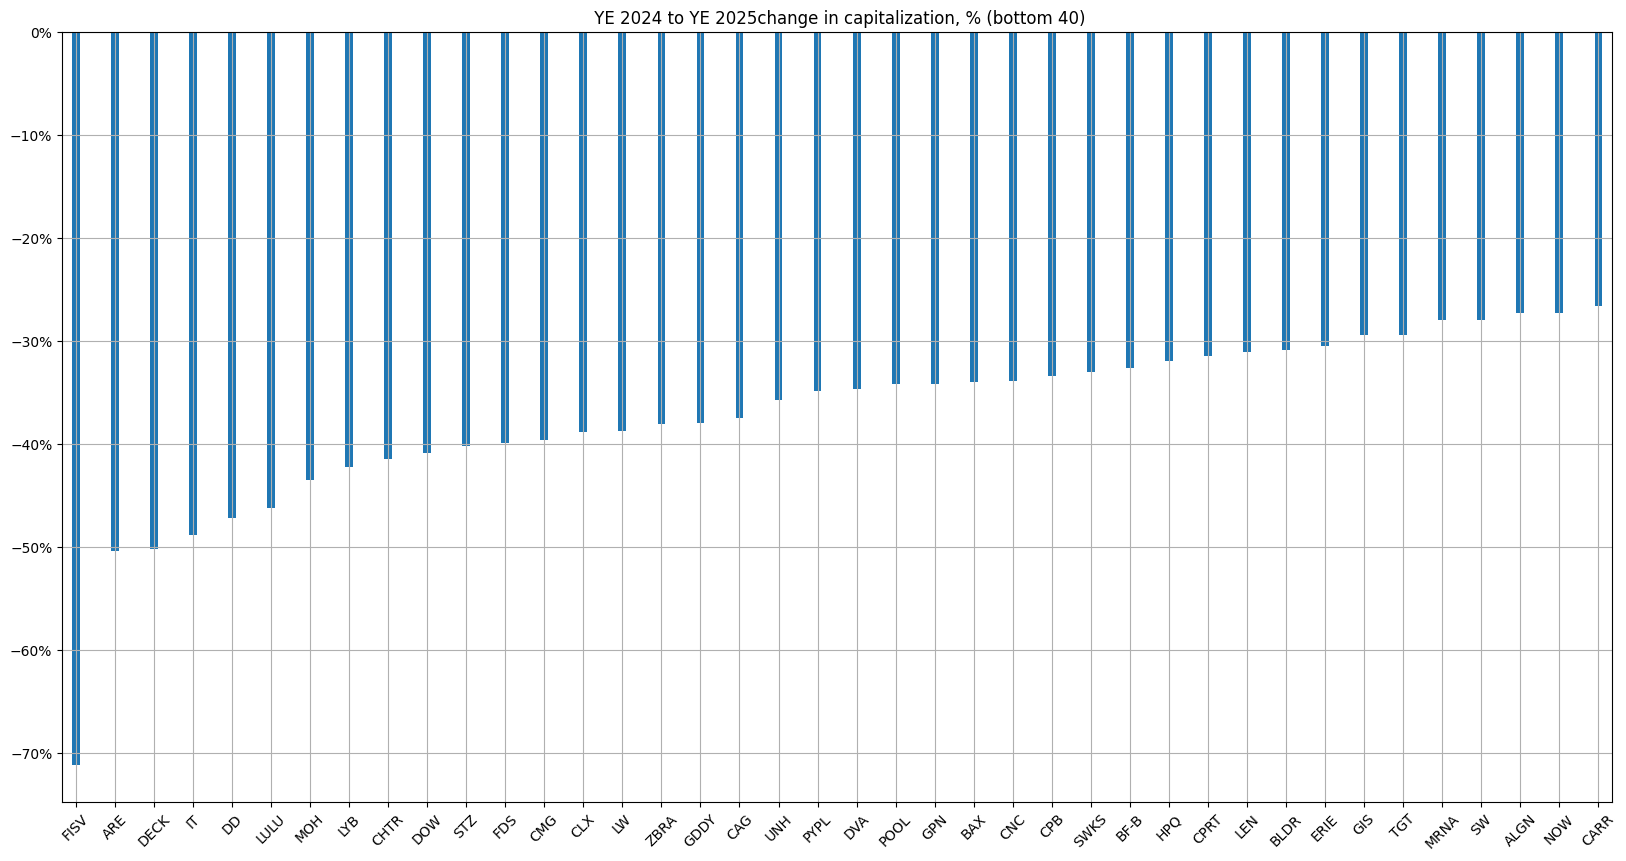

In [72]:
ax = cap_chg.iloc[:cut_off].plot.bar(figsize=(20,10), grid=True, rot=45, width=0.2, 
                                      title=TITLE_PFX + f' change in capitalization, % (bottom {cut_off})')
# Please uncomment if you want full names rather than ticker names
# ax.set_xticklabels([ticker_to_name[ticker] for ticker in cap_chg.iloc[:cut_off].index], rotation=45, ha='right')
ax.yaxis.set_major_formatter('{x:,.0%}')

## S&P 500 companies from the banking sector
One of the most frequently used tools for analyzing banks is their P/B and ROE ratios. Being traditional businesses for which book value is a meaningful metric, the following equation holds for banks:
$$\frac{P}{B}=\frac{ROE}{\text{Cost-of-equity} - g}$$
where:
* `P` is the market price of a bank's equity
* `B` is the book value of the bank's equity
* `ROE` is its return on equity
* `g` is an expected nominal growth of the bank's earnings

Therefore, a popular way to compare banks is to plot their P/B (price-to-book) ratios against their ROEs (return on equity). Banks whose ROE exceeds their cost of equity tend to have a P/B ratio greater than 1. If the cost of equity and earnings growth were the same for all banks, the points on this graph would form a line. However, since the cost of equity and earnings prospects differ slightly among financial institutions, this is not the case. Still, for banks that are part of the S&P 500, the points are fairly close, implying they have a similar cost of equity. Their approximate cost of equity can be derived from the above equation.

In the remainder of this notebook I will plot this for US Banks that are part of the S&P 500 index and derive their approximate cost of equity. As an approximation of `g`, I will use annualized _nominal_ GDP growth rate from the last quarter (alternatively I could use a year-on-year _nominal_ GDP growth rate from the last quarter). While incorrect for an individual bank, it is approximately correct as an average for the banking industry. I use P/B values based on the book value as reported in the most recent quarter (MRQ) and ROE based on the trailing twelve months (TTM).

I plot a linear regression line that shows a linear dependency between ROE and P/B values for the banks in the sample. The bigger the slope of the regression line, the smaller the cost of equity.

To identify banks, I focus on companies within the `Financial Services` sector, specifically those classified in one of the following industries:
* Banks - Diversified
* Banks - Regional
* Capital Markets

In [47]:
banking_sector_companies = sp500_metrics.get_banking_sector_components()
roe_pb = sp500_metrics.get_roe_and_pb(banking_sector_companies).dropna()
slope, intercept, rvalue, pvalue = scipy.stats.linregress(roe_pb.iloc[:,0].to_list(),
                                                          roe_pb.iloc[:,1].to_list())[0:4]

gdp = gdp.resample('QS').first().drop_duplicates()
# Uncomment the below if you want to use an annulized GDP growth from the last quarter instead of its year-on-year growth.
gdp_annualized = (gdp/gdp.shift(1)).pow(4) - 1

# Uncomment the below if you want to use a year-over-year nominal GDP growth rate
# gdp_annualized = gdp.rolling(4).mean().pct_change(4, fill_method=None)

g = gdp_annualized.iloc[-1]
names = sp500_metrics.tickers_to_display_names(banking_sector_companies)
ticker_to_name = dict(zip(banking_sector_companies, names))

In [48]:
def display_roe_pb(roe_pb_df, roe_cutoff=None, pb_cutoff=None, slope_intercept_r_p_value=None, expand_tickers=True):
    """
    Plots a ROE to P/B chart based on the DataFrame object 'roe_pb_df'

    :param roe_pb_df: A DataFrame index by ticker symbols and having two columns: ROE and P/B
    :param roe_cutoff: a pair designating the minimum and maximum ROE values to display
    :param pb_cutoff: a single value designating the maximum P/B value to display
    :param slope_intercept_r_p_value: a 4 value tuple to use for displaying a regression line, if None then
                                      a new linear regression tuple will be calculated based on the subset
                                      meeting the cutoff criteria specified by 'roe_cutoff' and 'pb_cutoff'
    :param expand_tickers: a boolean determining whether to convert ticker symbols into displayable company names
    :returns: a 5 value tuple comprising a DataFrame that meets the cut-off criteria and linear regression values
    """
    assert not (bool(roe_cutoff) ^ bool(pb_cutoff)), 'Either both cutoff values need to be provided or none'
    if roe_cutoff:
        roe_cutoff_min, roe_cutoff_max = roe_cutoff
        roe_pb_df = roe_pb_df.loc[(roe_pb.ROE < roe_cutoff_max) & (roe_pb.ROE > roe_cutoff_min) & (roe_pb['P/B'] < pb_cutoff)]

    slope, intercept, rvalue, pvalue = slope_intercept_r_p_value if slope_intercept_r_p_value else \
                    scipy.stats.linregress(roe_pb_df.iloc[:,0].to_list(), roe_pb_df.iloc[:,1].to_list())[0:4]

    fig, ax = plt.subplots(figsize=(20, 10))
    sc = ax.scatter(x=roe_pb_df.iloc[:,0], y=roe_pb_df.iloc[:,1])

    x_min = roe_pb_df.iloc[:,0].min()
    ax.axline((x_min, intercept + slope * x_min), slope=slope, linestyle='--', color='k', linewidth=.5)

    labels = [f'Slope = {slope/100:.3f}', f'$R^2$ = {rvalue**2:.3f}', f'p-value = {pvalue:.2g}']
    ax.legend([ax.plot([],[])[0] for _ in labels], labels, handlelength=0, handleheight=0, handletextpad=0)

    # Add labels to designate each bank
    for ticker, (roe, pb) in roe_pb_df.iterrows():
        plt.text(roe, pb, ticker_to_name[ticker] if expand_tickers else ticker, ha='left', va='bottom')
    
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
    ax.set_xlabel(roe_pb.columns[0] + TTM_SUFFIX)
    ax.set_ylabel(roe_pb.columns[1] + MRQ_SUFFIX)
    ax.set_title('Price to Book vs ROE of US Banks'
                 +  (f' (subset: {roe_cutoff_min:.0%}% < ROE < {roe_cutoff_max:.0%} and P/B < {pb_cutoff})' if roe_cutoff else '')
                 + f' on {sp500_metrics.capitalization.index[-1]:%Y-%m-%d}')
    ax.grid(True)
    return (roe_pb_df, slope, intercept, rvalue, pvalue)

def print_cost_of_equity(roe_pb_df, slope, g):
    print(f'The sensitivity of P/B to ROE for US banks: {slope/100:.2f}\n'
          f"This means that for every percentage point improvement in ROE, the bank's P/B increases by {slope/100:.2f}\n")
    print(f'From the above equation it also means that an approximate cost of equity for these banks is: {1./slope + g:.2%}')
    print(roe_pb_df.index.to_list())

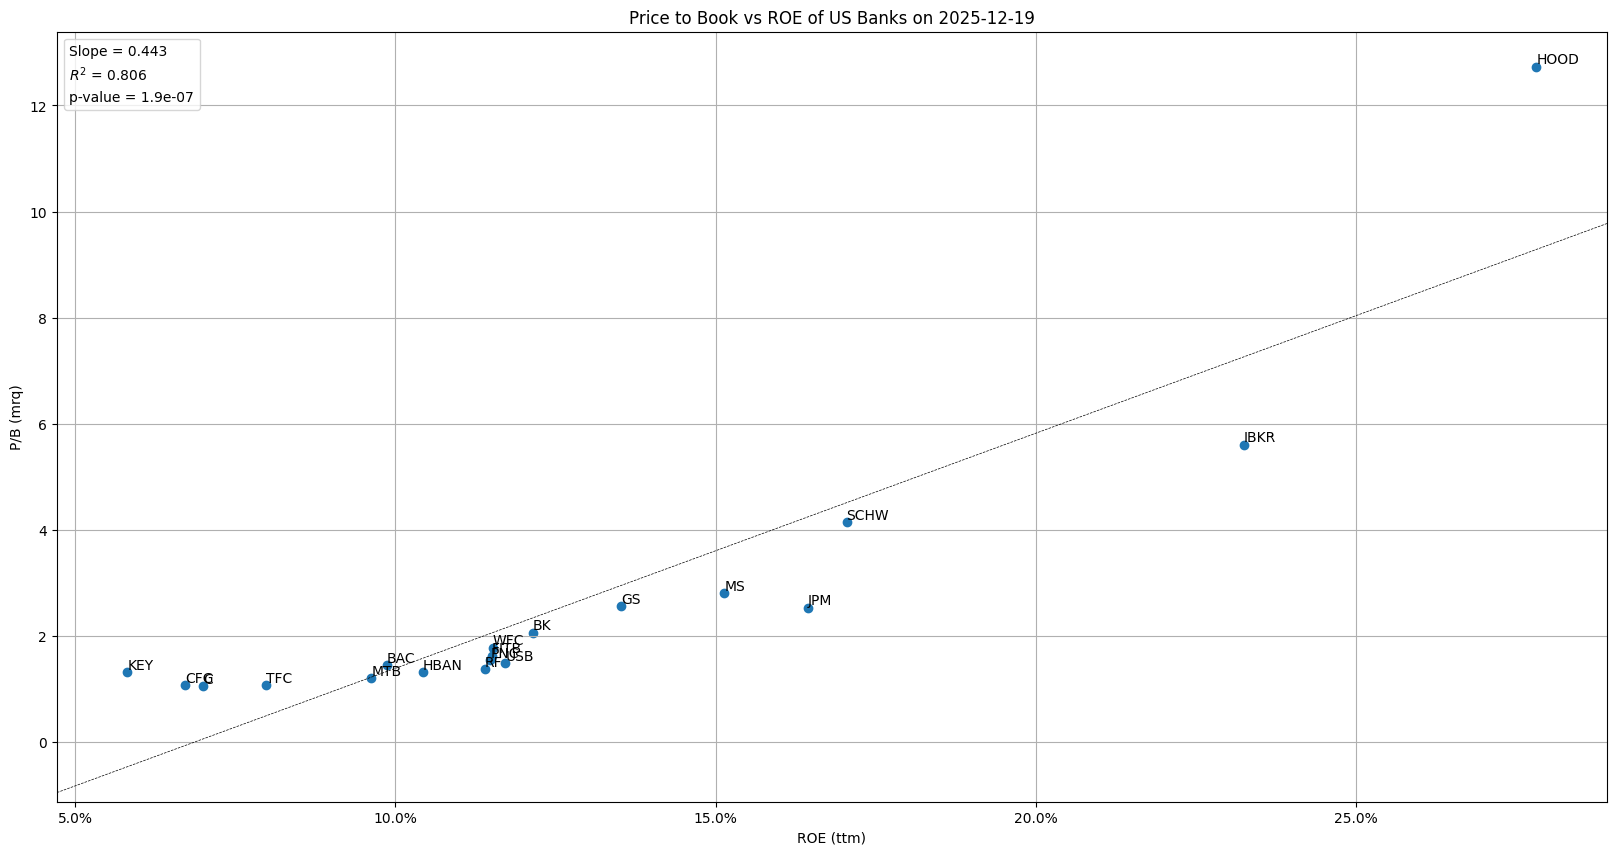

In [49]:
_ = display_roe_pb(roe_pb, slope_intercept_r_p_value=(slope, intercept, rvalue, pvalue), expand_tickers=False)

In [50]:
print_cost_of_equity(roe_pb, slope, g)

The sensitivity of P/B to ROE for US banks: 0.44
This means that for every percentage point improvement in ROE, the bank's P/B increases by 0.44

From the above equation it also means that an approximate cost of equity for these banks is: 8.30%
['GS', 'CFG', 'IBKR', 'HOOD', 'SCHW', 'FITB', 'MS', 'BAC', 'HBAN', 'JPM', 'RF', 'TFC', 'KEY', 'WFC', 'C', 'USB', 'PNC', 'MTB', 'BK']


Now let's zoom in on the cluster of banks with ROE between 0% and 20% and P/B ratios less than 3. I will also construct a regression line to determine the sensitivity of P/B to changes in ROE.

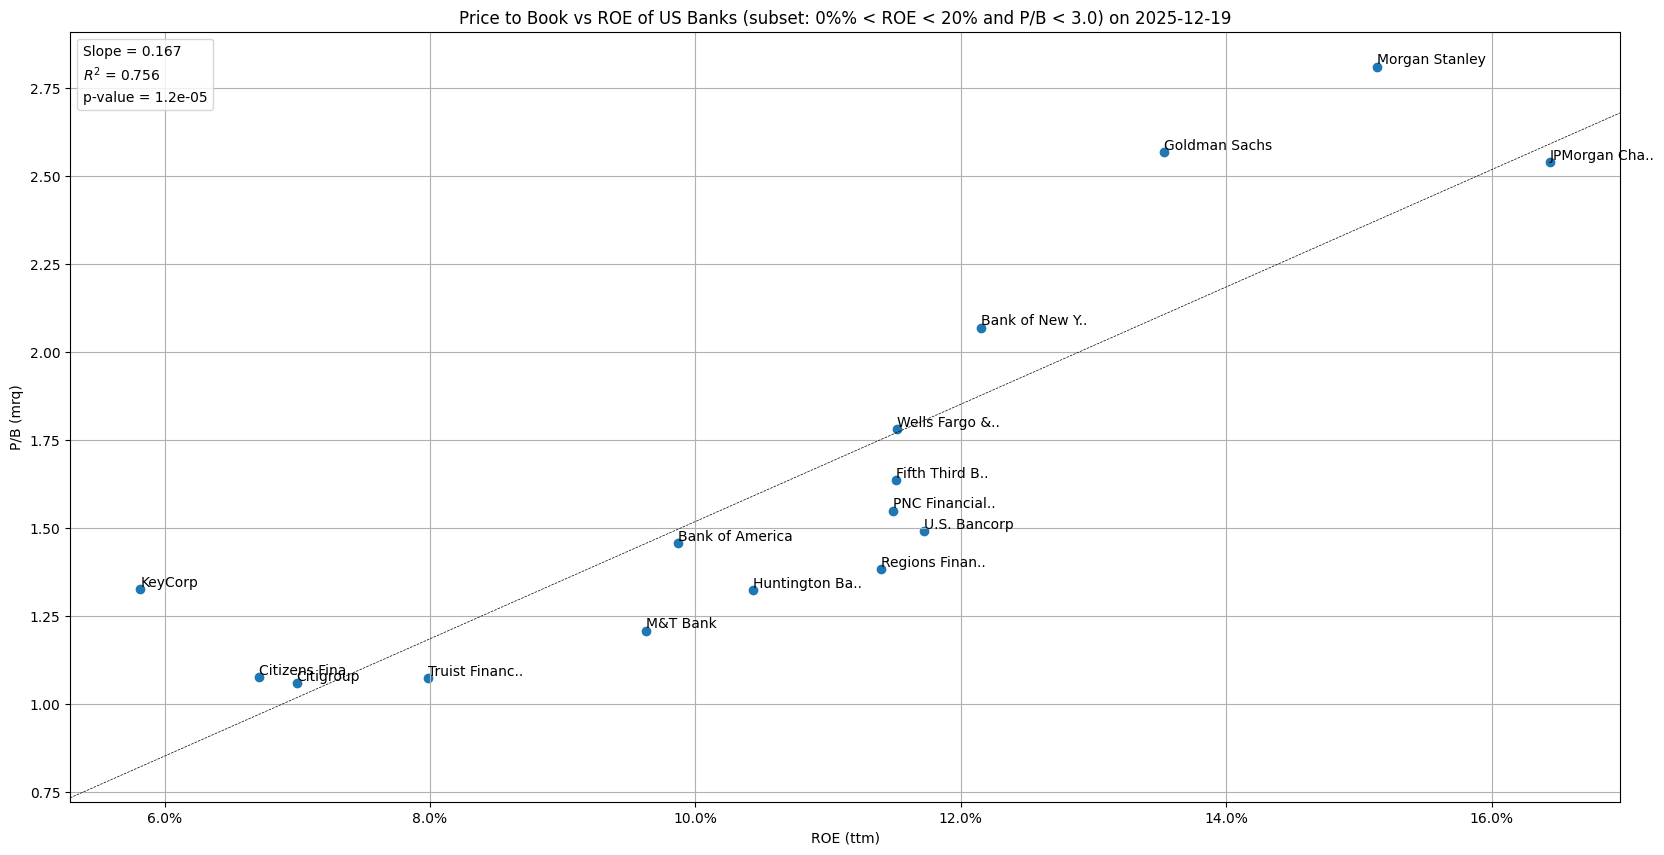

In [51]:
# Define the subset to zoom into
roe_cutoff = (0, .2)
pb_cutoff = 3.

# Reusing linear regression data from the whole set of banks
# roe_pb_subset, _, _, _, _ = display_roe_pb(roe_pb, roe_cutoff, pb_cutoff, (slope, intercept, rvalue, pvalue))

# Uncomment if you want to recalculate linear regression for the subset
roe_pb_subset, slope, intercept, rvalue, pvalue = display_roe_pb(roe_pb, roe_cutoff, pb_cutoff)

In [52]:
print_cost_of_equity(roe_pb_subset, slope, g)

The sensitivity of P/B to ROE for US banks: 0.17
This means that for every percentage point improvement in ROE, the bank's P/B increases by 0.17

From the above equation it also means that an approximate cost of equity for these banks is: 12.04%
['GS', 'CFG', 'FITB', 'MS', 'BAC', 'HBAN', 'JPM', 'RF', 'TFC', 'KEY', 'WFC', 'C', 'USB', 'PNC', 'MTB', 'BK']


The R<sup>2</sup> of more than 0.5 indicates a significant linear dependence of a bank's price-to-book ratio on its ROE. The p-value of 0.001 provides sufficient evidence to reject the null hypothesis that there is no correlation between banks' price-to-book ratios and their ROEs.

### Analysis of changes in ROE to P/B
For this analysis I use data that I have privately computed, which I haven't yet made public. Hence the majority of cells are commented out.

In [53]:
from pandas.tseries.offsets import QuarterEnd
import os
last_qe = QuarterEnd(0).rollback(date.today())
banks_roe = roe_pb.loc[:, 'ROE'].to_frame(last_qe.date())
banks_pb = roe_pb.loc[:, 'P/B'].to_frame(last_qe.date())

In [60]:
# if os.path.isfile(os.path.expanduser(f'~/historical_equity_data/sp500_banks_roe.cvs')):
#     f = pd.read_csv(f'~/historical_equity_data/sp500_banks_roe.cvs', index_col=0)
#     banks_roe = pd.concat([banks_roe, f], axis=1)
#     banks_roe.set_axis(pd.DatetimeIndex(banks_roe.columns), axis=1)

# if os.path.isfile(os.path.expanduser(f'~/historical_equity_data/sp500_banks_pb.cvs')):
#     f = pd.read_csv(f'~/historical_equity_data/sp500_banks_pb.cvs', index_col=0)
#     banks_pb = pd.concat([banks_pb, f], axis=1)
#     banks_pb.set_axis(pd.DatetimeIndex(banks_pb.columns), axis=1)

In [61]:
# # The quater for YTD comparison
# months_ago = sp500_metrics.data.index[-1].date().month
# quarter_end = str(pd.offsets.MonthEnd(0).rollforward(sp500_metrics.data.index[-1] - pd.DateOffset(months=months_ago)).date())

# roe_lq = banks_roe.loc[:,quarter_end]
# pb_lq = banks_pb.loc[:,quarter_end]
# roe_lq = roe_lq.loc[roe_pb_subset.index]
# pb_lq = pb_lq.loc[roe_pb_subset.index]

# roe_pb_subset_lq = pd.concat([roe_lq, pb_lq], axis=1)
# roe_pb_subset_lq.columns = roe_pb_subset.columns

# slope_lq, intercept_lq = scipy.stats.linregress(roe_pb_subset_lq.dropna().iloc[:,0].to_list(),
#                                                 roe_pb_subset_lq.dropna().iloc[:,1].to_list())[0:2]

# idx_exclude = roe_pb_subset_lq[roe_pb_subset_lq.ROE < 0].index
# roe_pb_subset = roe_pb_subset.loc[~roe_pb_subset.index.isin(idx_exclude)]
# roe_pb_subset_lq = roe_pb_subset_lq.loc[~roe_pb_subset_lq.index.isin(idx_exclude)]

In [62]:
# def display_roe_pb_transitions(roe_pb_subset, roe_pb_subset_lq, columns,
#                                display_slopes=False):
#     fig, ax = plt.subplots(figsize=(20, 10))
#     sc = ax.scatter(x=roe_pb_subset.iloc[:,0], y=roe_pb_subset.iloc[:,1])
#     sc3 = ax.scatter(x=roe_pb_subset_lq.iloc[:,0], y=roe_pb_subset_lq.iloc[:,1], marker='h', color='#2ca02c')
    
#     for index, row in roe_pb_subset_lq.iterrows():
#         x_start, x_end = row.iloc[0], roe_pb_subset.loc[index, roe_pb_subset.columns[0]]
#         y_start, y_end = row.iloc[1], roe_pb_subset.loc[index, roe_pb_subset.columns[1]]
#         ax.plot([x_start, x_end], [y_start, y_end], ls='--', color='#1f77b4', lw=.5)
#         if np.all(~np.isnan(np.array([x_start, y_start, x_end, y_end]))):
#             ax.annotate(
#                 '',  # No text
#                 xy=(x_end, y_end),      # Arrow tip (end point)
#                 xytext=(x_start, y_start),  # Arrow tail (start point)
#                 arrowprops=dict(arrowstyle='-|>,head_width=.3,head_length=.7', color='#1f77b4', lw=0.5, linestyle='--')
#             )

#     if display_slopes:
#         x_min = roe_pb_subset.iloc[:,0].min()
#         ax.axline((x_min, intercept + slope * x_min), slope=slope, linestyle='--', color='k', linewidth=.5)
#         plt.text(x_min, intercept + slope * x_min + .02, f'Slope = {slope/100:.2f}')
        
#         x_min_lq = roe_pb_subset_lq.iloc[:,0].min()
#         ax.axline((x_min_lq, intercept_lq + slope_lq * x_min_lq), slope=slope_lq, linestyle='--', color='g', linewidth=.5)
#         plt.text(x_min_lq, intercept_lq + slope_lq * x_min_lq + .02, f'Slope = {slope_lq/100:.2f}')
    
#     # Add labels to designate each bank
#     for ticker, (roe, pb) in roe_pb_subset.iterrows():
#         plt.text(roe, pb, ticker_to_name[ticker], ha='left', va='bottom')
        
#     ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
#     ax.set_xlabel(roe_pb.columns[0] + TTM_SUFFIX)
#     ax.set_ylabel(roe_pb.columns[1] + MRQ_SUFFIX)
#     ax.set_title(f'Price to Book vs ROE of S&P500 Banks ' +
#                  f'on {sp500_metrics.capitalization.index[-1]:%Y-%m-%d}')
#     ax.legend([sc, sc3], [f'Quarter end {qe}' for qe in columns])
#     ax.grid(True)

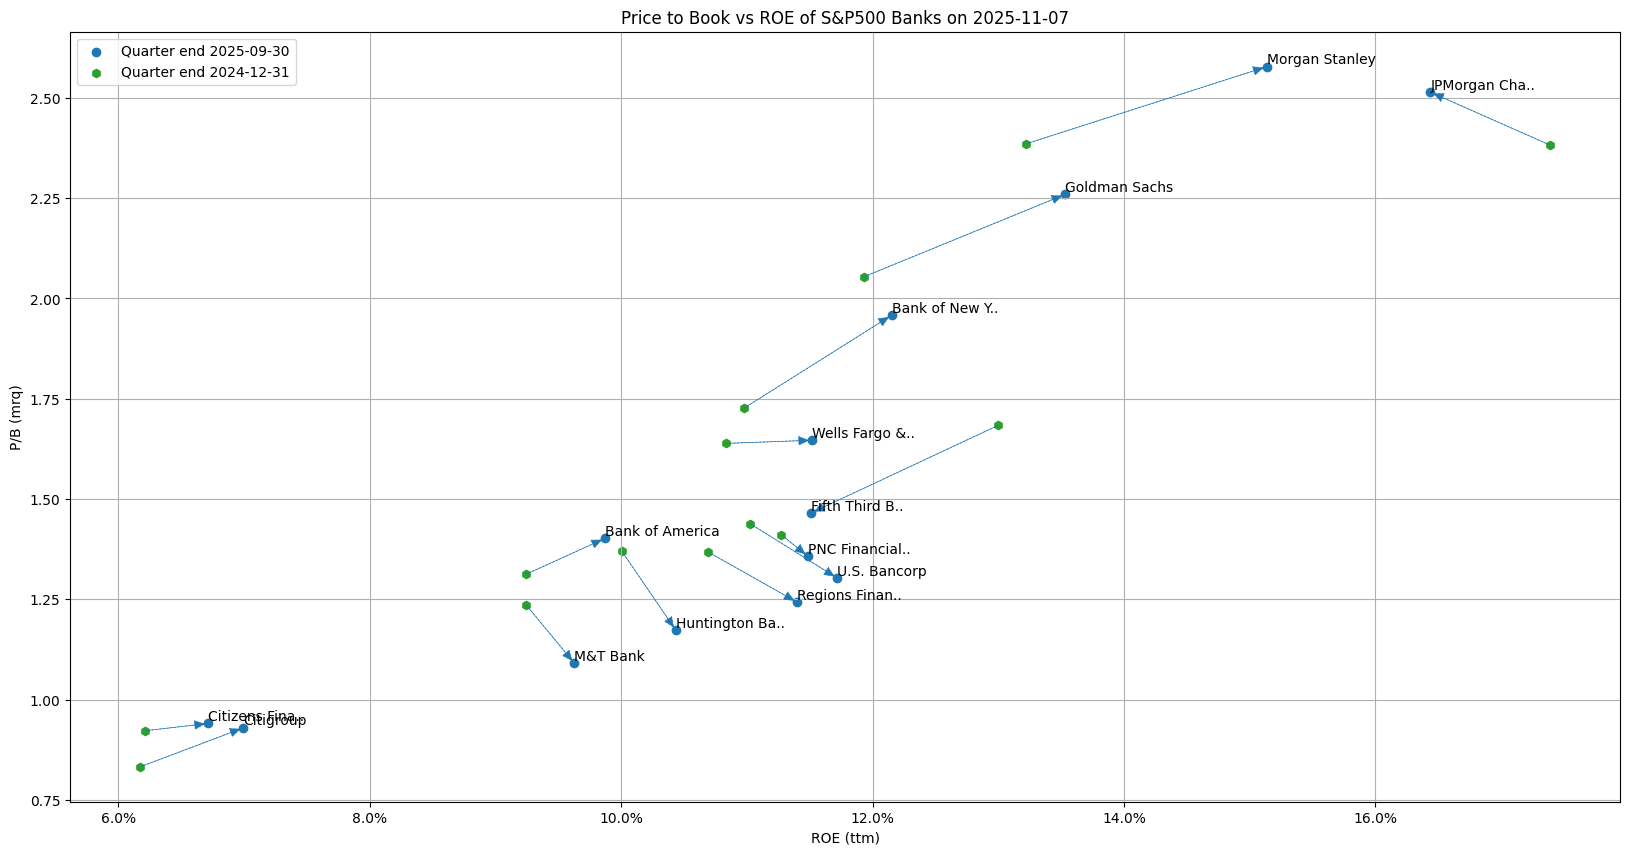

In [63]:
display_roe_pb_transitions(roe_pb_subset, roe_pb_subset_lq, [banks_roe.columns[0], quarter_end])

### Capitalization changes among S&P 500 Banks
Let's compare how much the capitalization of US Banks that are members of the S&P 500 has changed over the past n months.

In [54]:
months_ago = 12
TITLE_PFX = 'Year-over-Year '

# Uncomment if you want to look at YTD changes
# months_ago = sp500_metrics.data.index[-1].date().month
# TITLE_PFX = 'YTD '
banks_cap = sp500_metrics.get_capitalization_for_companies(banking_sector_companies, method='last')
banks_cap_now = banks_cap.iloc[-1]
date_n_months_ago = pd.offsets.MonthEnd(0).rollforward(banks_cap.index[-1] - pd.DateOffset(months=months_ago))
banks_cap_n_months_ago = banks_cap.loc[date_n_months_ago]
banks_cap_df = (pd.concat([banks_cap_n_months_ago, banks_cap_now], axis=1) / 1e9).dropna()
banks_cap_df.columns = [sp500_metrics.CAPITALIZATION + sfx for sfx in [f' {months_ago} months ago', ' now']]

In [55]:
banks_cap_chg = banks_cap_df.iloc[1:].pct_change(axis=1, fill_method=None).iloc[:, 1].sort_values()
banks_cap_chg

MTB     3.10%
PNC     7.94%
TFC    12.13%
FITB   12.64%
USB    12.96%
RF     15.46%
HBAN   17.86%
BAC    21.40%
WFC    27.40%
JPM    29.25%
CFG    32.39%
SCHW   32.40%
KEY    35.40%
MS     39.49%
BK     46.25%
GS     50.47%
C      58.83%
Name: Capitalization now, dtype: float64

In [56]:
print(f'Overall capitalization of S&P 500 changed by {banks_cap_df.iloc[0].pct_change().iloc[1]:+.2%}'
      f' since {date_n_months_ago:%Y-%m-%d}')

Overall capitalization of S&P 500 changed by +17.16% since 2024-12-31


In [57]:
print(f'Overall capitalization of banks that are part of S&P 500 changed by {banks_cap_df.iloc[1:].sum().pct_change().iloc[1]:+.2%}'
      f' (${banks_cap_df.iloc[1:].sum().diff().iloc[1]:+.0f}bn) since {date_n_months_ago:%Y-%m-%d}')

Overall capitalization of banks that are part of S&P 500 changed by +30.38% ($+699bn) since 2024-12-31


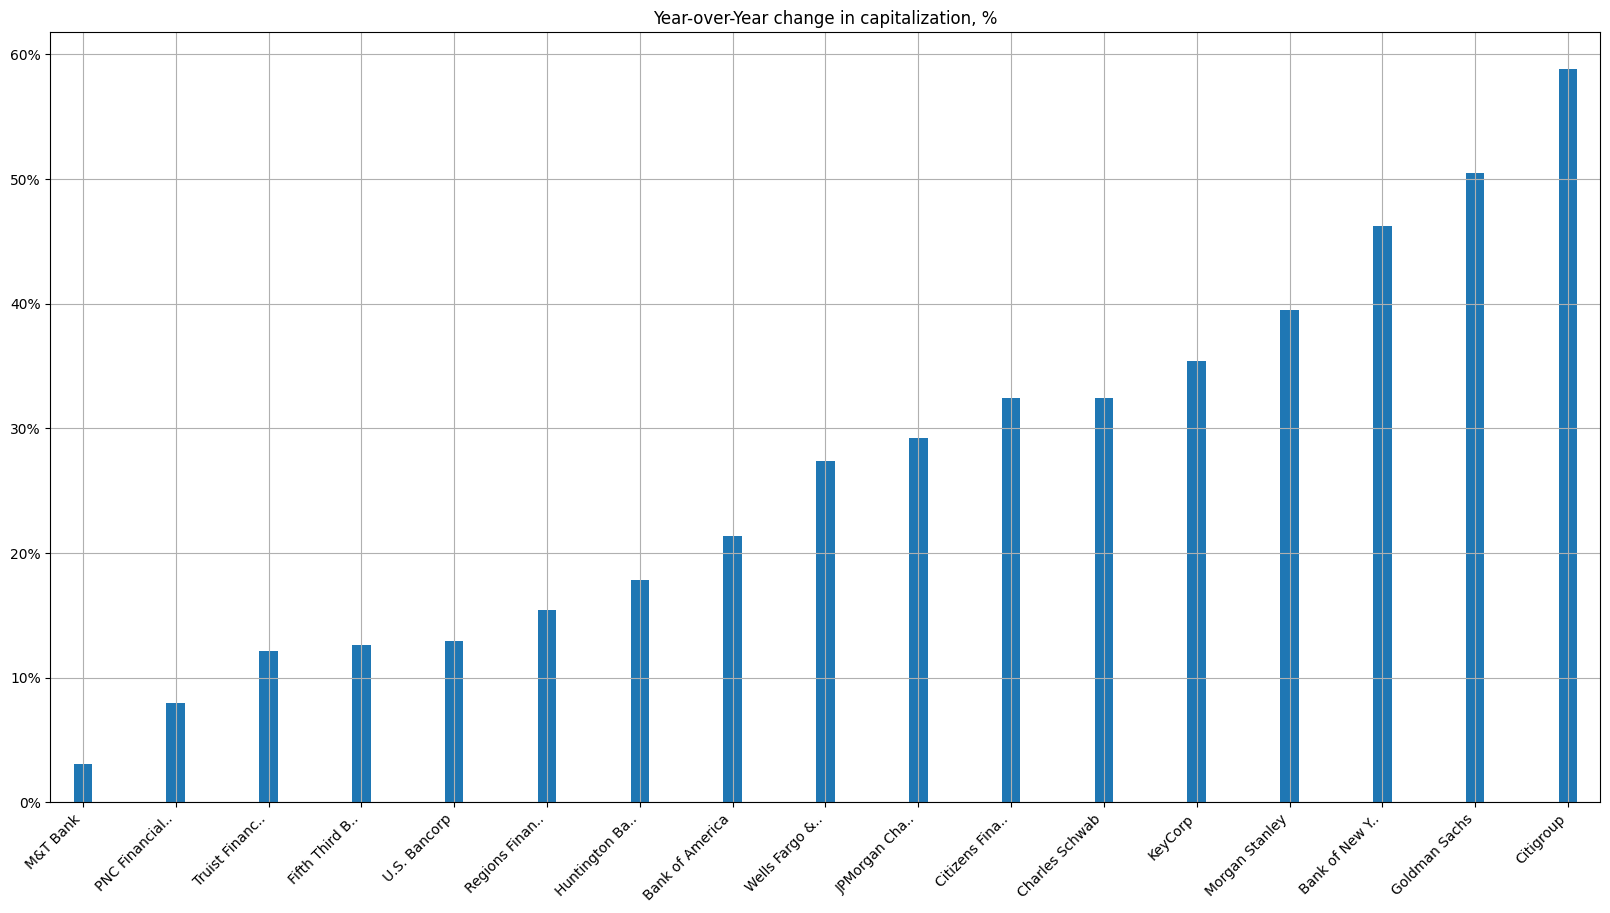

In [58]:
ax = banks_cap_chg.plot.bar(figsize=(20,10), grid=True, rot=45, width=0.2,
                            title=TITLE_PFX + 'change in capitalization, %')
ax.set_xticklabels([ticker_to_name[ticker] for ticker in banks_cap_chg.index], rotation=45, ha='right')
ax.yaxis.set_major_formatter('{x:,.0%}')

### Revenue, Income, CAPEX, Acquisitions, and Dividends Growth of the Magnificent Seven Companies
In this part of the notebook, I calculate the cumulative revenue, pretax income, net income, tax, CAPEX, acquisitions, and dividends of the Magnificent Seven companies (Apple, Amazon, Alphabet, Meta, Microsoft, Nvidia, and Broadcom) and examine how they evolve over time. I compute both nominal and real growth for these metrics, adjusting for inflation using the GDP deflator.

In [74]:
istmt, sector_istmt = sp500_metrics.get_quarterly_stmt_data(tickers=MAGN_SEVEN)

Ignoring additional share class for GOOG to avoid double counting


In [79]:
pd.options.display.float_format = (lambda x: '{:.2%}'.format(x) if abs(x) < 5 else '${:,.2f}bn'.format(x/1e9))

In [81]:
istmt

,2025-09-30,2025-06-30,2025-03-31,2024-12-31,2024-09-30
Total Revenue,$576.59bn,$541.19bn,$507.89bn,$575.71bn,$491.36bn
Pretax Income,$197.42bn,$162.97bn,$173.24bn,$176.17bn,$149.46bn
Net Income,$144.65bn,$139.10bn,$146.51bn,$151.45bn,$111.44bn
Tax Provision,$52.69bn,$23.85bn,$26.74bn,$24.82bn,$37.57bn
Capital Expenditure,$-102.55bn,$-93.08bn,$-76.15bn,$-76.21bn,$-62.92bn
Purchase Of Business,$-3.48bn,$-3.84bn,$-1.86bn,$-4.19bn,$-5.64bn
Cash Dividends Paid,$-16.93bn,$-17.01bn,$-16.71bn,$-16.47bn,$-15.79bn


In [76]:
gdp_defl = web.get_data_fred('GDPDEF', start=istmt.columns[-1]-QuarterEnd(1), end=istmt.columns[0])
gdp_defl = gdp_defl.resample('QE').last().GDPDEF

In [77]:
gdp_defl.iloc[-1] / gdp_defl

DATE
2024-09-30   102.03%
2024-12-31   101.42%
2025-03-31   100.53%
2025-06-30   100.00%
Freq: QE-DEC, Name: GDPDEF, dtype: float64

In [78]:
istmt_real = istmt.multiply(gdp_defl.iloc[-1] / gdp_defl, axis=1).reindex(columns=istmt.columns)

In [80]:
istmt_real

,2025-09-30,2025-06-30,2025-03-31,2024-12-31,2024-09-30
Total Revenue,NaN,$541.19bn,$510.56bn,$583.90bn,$501.34bn
Pretax Income,NaN,$162.97bn,$174.16bn,$178.68bn,$152.50bn
Net Income,NaN,$139.10bn,$147.28bn,$153.60bn,$113.71bn
Tax Provision,NaN,$23.85bn,$26.88bn,$25.17bn,$38.34bn
Capital Expenditure,NaN,$-93.08bn,$-76.55bn,$-77.30bn,$-64.20bn
Purchase Of Business,NaN,$-3.84bn,$-1.87bn,$-4.25bn,$-5.75bn
Cash Dividends Paid,NaN,$-17.01bn,$-16.80bn,$-16.70bn,$-16.11bn


In [86]:
yoy_growth = pd.concat([istmt.iloc[:,::-1].pct_change(4, axis=1).iloc[:,-1], istmt_real.iloc[:,::-1]
    .pct_change(4, axis=1, fill_method=None).iloc[:,-1]], axis=1, keys=['Nominal', 'Real'])
yoy_growth = yoy_growth.reindex(yoy_growth.index[[0,1,3,2,4,5,6]])

In [87]:
yoy_growth.reindex(yoy_growth.index[[0,1,3,2,4,5,6]])

,Nominal,Real
Total Revenue,17.35%,NaN
Pretax Income,32.08%,NaN
Net Income,29.80%,NaN
Tax Provision,40.24%,NaN
Capital Expenditure,62.99%,NaN
Purchase Of Business,-38.20%,NaN
Cash Dividends Paid,7.17%,NaN


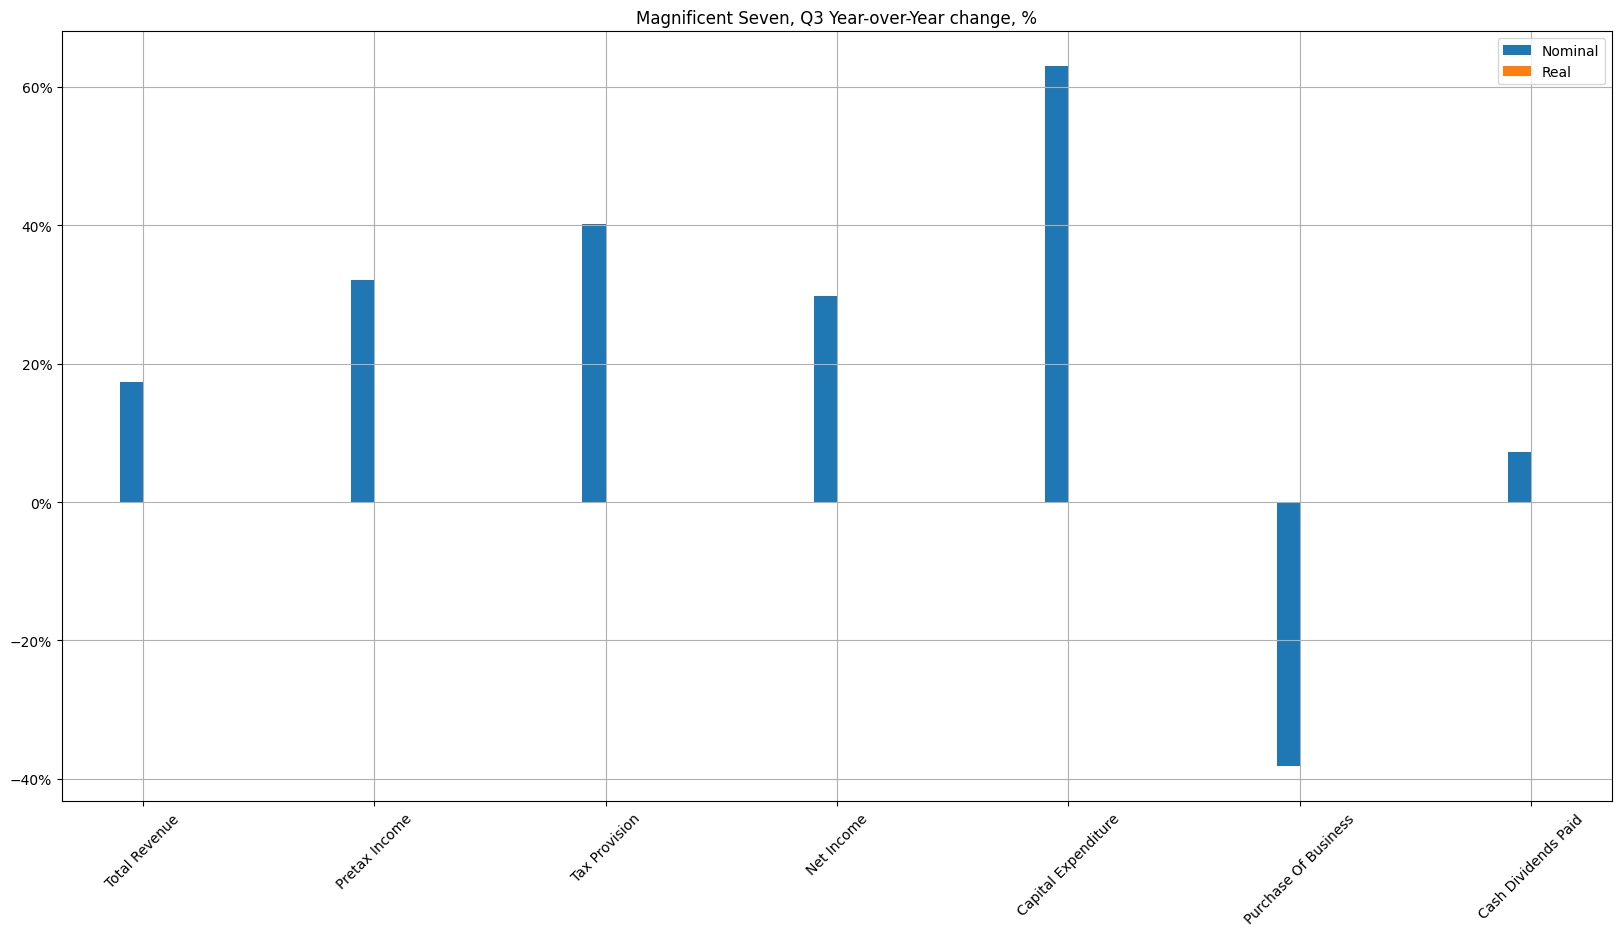

In [88]:
ax = yoy_growth.plot.bar(figsize=(20,10), grid=True, rot=45, width=0.2,
                         title=f'Magnificent Seven, Q{istmt_real.columns[0].quarter} Year-over-Year change, %')
ax.yaxis.set_major_formatter('{x:,.0%}')

In [46]:
pd.options.display.float_format=None

### Revenue, Income, CAPEX, Acquisitions, and Dividends Growth of all S&P500 Companies
In this part of the notebook, I calculate the cumulative revenue, pretax income, net income, tax, CAPEX, acquisitions, and dividends of all companies that are part of the index and compare it with those of the previous calendar year. I compute both nominal and real growth for these metrics, adjusting for inflation using the GDP deflator.

I make use of Yahoo-Finance data that I earlier saved, which is not retrievable anymore. I haven't yet made it part of the repository, so some cells are commented out.

In [59]:
istmt, sector_istmt = sp500_metrics.get_quarterly_stmt_data()

Need to provide values for LULU for 2024-09-30
For ARE missing the following income statement lines:
Index(['Tax Provision'], dtype='object')
Need to provide values for CPRT for 2024-09-30
Need to provide values for NDSN for 2024-09-30
Need to provide values for HRL for 2024-09-30
Need to provide values for CRWD for 2024-09-30
Yahoo Finance doesn't have income statement for MRO for the following quarters
DatetimeIndex(['2024-09-30'], dtype='datetime64[ns]', freq='-1QE-DEC')
Yahoo Finance doesn't have income statement for CTLT for the following quarters
DatetimeIndex(['2024-09-30'], dtype='datetime64[ns]', freq='-1QE-DEC')
Need to provide values for CPB for 2024-09-30
Need to provide values for INTU for 2024-09-30
Need to provide values for MDT for 2024-09-30
Need to provide values for TJX for 2024-09-30
Need to provide values for GIS for 2024-09-30
Need to provide values for COO for 2024-09-30
Need to provide values for TGT for 2024-09-30
Need to provide values for PANW for 2024-09-30


In [56]:
# f = pd.read_csv('~/historical_equity_data/sp500_quarterly_stmts.cvs', index_col=0)
# f.columns = pd.DatetimeIndex(f.columns)
# istmt = pd.concat([istmt.iloc[:,0], f], axis=1)
# istmt.to_csv('~/historical_equity_data/sp500_quarterly_stmts.cvs')

In [57]:
istmt

,2025-09-30,2025-06-30,2025-03-31,2024-12-31,2024-09-30,2024-06-30,2024-03-31,2023-12-31,2023-09-30,2023-06-30,2023-03-31
Total Revenue,4.657443e+12,4.479797e+12,4.286369e+12,4.448649e+12,4.348100e+12,4.215561e+12,4.078625e+12,4.223427e+12,4.049496e+12,4.013200e+12,3.946565e+12
Pretax Income,7.565677e+11,6.515007e+11,6.119463e+11,6.184662e+11,6.118388e+11,6.069611e+11,5.279085e+11,5.086743e+11,5.305298e+11,5.353646e+11,5.477101e+11
Net Income,5.742020e+11,5.238579e+11,4.868315e+11,5.291507e+11,4.660288e+11,4.805333e+11,4.276536e+11,4.340105e+11,4.531592e+11,4.369723e+11,4.369979e+11
Tax Provision,1.750406e+11,1.209101e+11,1.155288e+11,8.619360e+10,1.424030e+11,1.218746e+11,1.050232e+11,7.268382e+10,9.521680e+10,1.010898e+11,1.115963e+11
Capital Expenditure,-3.341850e+11,-3.119610e+11,-2.836858e+11,-3.117500e+11,-2.831772e+11,-2.531065e+11,-2.419367e+11,-2.727927e+11,-2.466495e+11,-2.344714e+11,-2.294333e+11
Purchase Of Business,-9.298815e+10,-6.191596e+10,-6.181386e+10,-7.152013e+10,-6.314306e+10,-7.249646e+10,-1.144968e+11,-1.664309e+11,-5.133473e+10,-4.351732e+10,-6.641534e+10
Cash Dividends Paid,-1.826230e+11,-1.733167e+11,-1.780543e+11,-1.752694e+11,-1.665181e+11,-1.618185e+11,-1.708584e+11,-1.596035e+11,-1.519115e+11,-1.507414e+11,-1.575781e+11


In [60]:
gdp_defl = web.get_data_fred('GDPDEF', start=istmt.columns[-1]-pd.offsets.QuarterEnd(1), end=istmt.columns[0])
gdp_defl = gdp_defl.resample('QE').last().GDPDEF

In [61]:
istmt_real = istmt.multiply(gdp_defl.iloc[-1] / gdp_defl, axis=1).reindex(columns=istmt.columns)

In [62]:
istmt_real

,2025-09-30,2025-06-30,2025-03-31,2024-12-31,2024-09-30,2024-06-30,2024-03-31,2023-12-31,2023-09-30,2023-06-30,2023-03-31
Total Revenue,NaN,4.479797e+12,4.308914e+12,4.511904e+12,4.436379e+12,4.319327e+12,4.205666e+12,4.389174e+12,4.225229e+12,4.221497e+12,4.173035e+12
Pretax Income,NaN,6.515007e+11,6.151649e+11,6.272602e+11,6.242609e+11,6.219015e+11,5.443518e+11,5.286371e+11,5.535527e+11,5.631516e+11,5.791400e+11
Net Income,NaN,5.238579e+11,4.893921e+11,5.366747e+11,4.754906e+11,4.923617e+11,4.409742e+11,4.510432e+11,4.728246e+11,4.596525e+11,4.620746e+11
Tax Provision,NaN,1.209101e+11,1.161365e+11,8.741919e+10,1.452942e+11,1.248746e+11,1.082944e+11,7.553628e+10,9.934884e+10,1.063366e+11,1.180001e+11
Capital Expenditure,NaN,-3.119610e+11,-2.851779e+11,-3.161828e+11,-2.889265e+11,-2.593367e+11,-2.494725e+11,-2.834984e+11,-2.573532e+11,-2.466411e+11,-2.425991e+11
Purchase Of Business,NaN,-6.191596e+10,-6.213898e+10,-7.253707e+10,-6.442505e+10,-7.428096e+10,-1.180632e+11,-1.729625e+11,-5.356246e+10,-4.577600e+10,-7.022652e+10
Cash Dividends Paid,NaN,-1.733167e+11,-1.789908e+11,-1.777616e+11,-1.698989e+11,-1.658017e+11,-1.761803e+11,-1.658671e+11,-1.585039e+11,-1.585654e+11,-1.666205e+11


In [64]:
yoy_growth = pd.concat([istmt.iloc[:,::-1].pct_change(4, axis=1, fill_method=None).iloc[:,-1],
                        istmt_real.iloc[:,::-1].pct_change(4, axis=1, fill_method=None).iloc[:,-1]],
                       axis=1, keys=['Nominal', 'Real'])
yoy_growth = yoy_growth.reindex(yoy_growth.index[[0,1,3,2,4,5,6]])

In [65]:
yoy_growth.reindex(yoy_growth.index[[0,1,3,2,4,5,6]])

,Nominal,Real
Total Revenue,0.071144,NaN
Pretax Income,0.236547,NaN
Net Income,0.232117,NaN
Tax Provision,0.229192,NaN
Capital Expenditure,0.180127,NaN
Purchase Of Business,0.472658,NaN
Cash Dividends Paid,0.096716,NaN


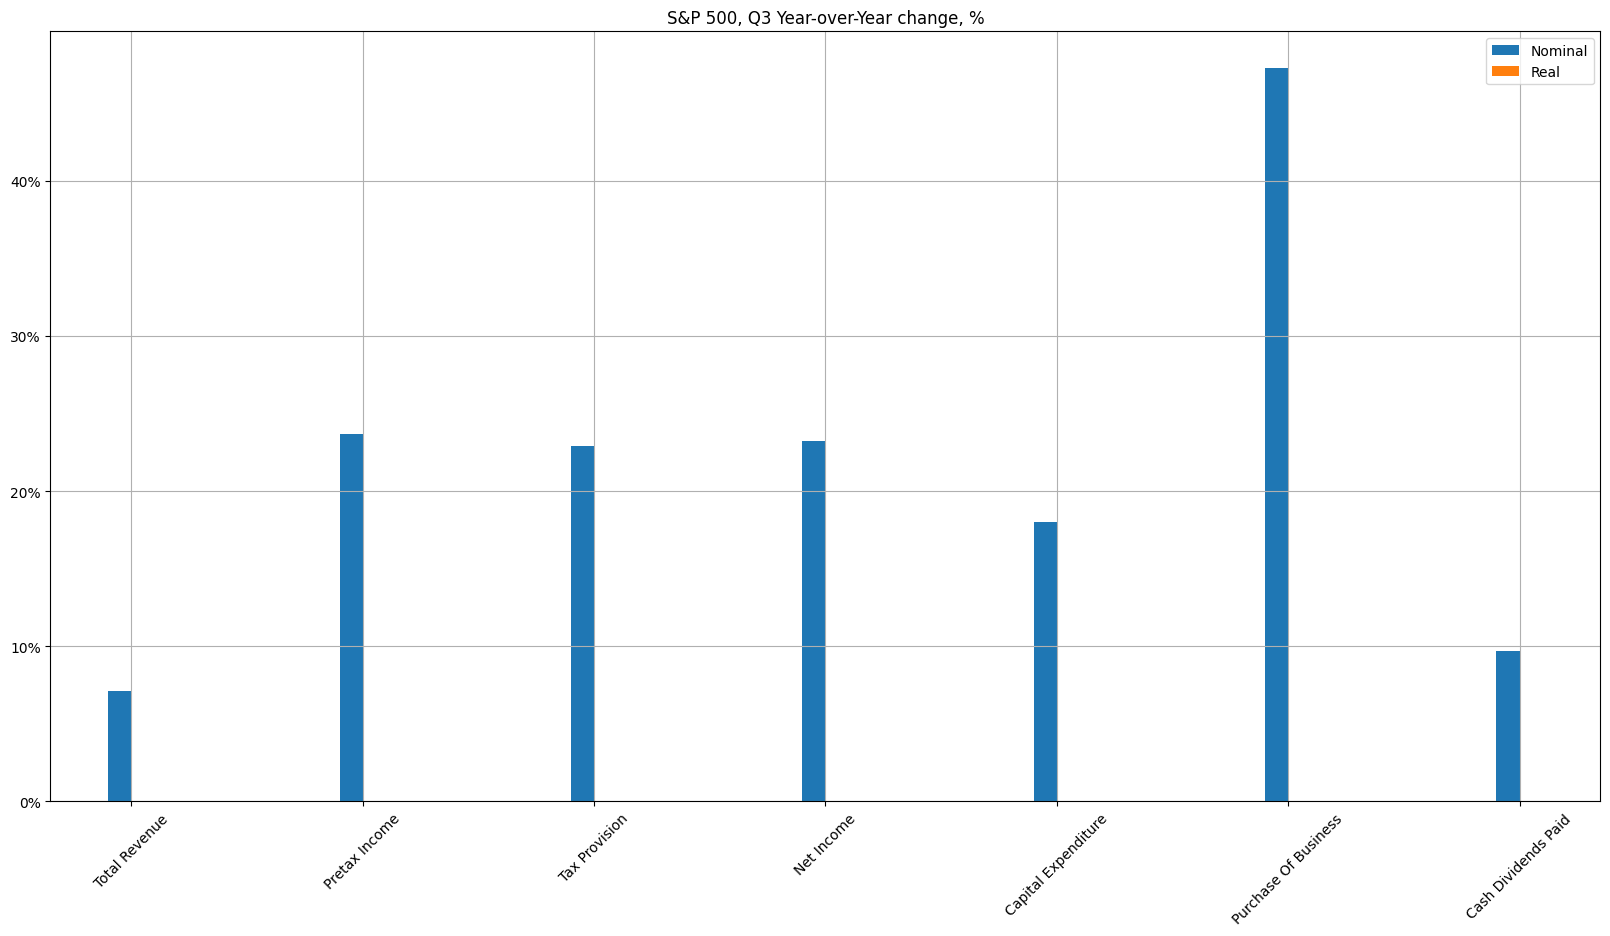

In [66]:
ax = yoy_growth.plot.bar(figsize=(20,10), grid=True, rot=45, width=0.2,
                         title=f'S&P 500, Q{istmt_real.columns[0].quarter} Year-over-Year change, %')
ax.yaxis.set_major_formatter('{x:,.0%}')

#### YTD vs YTD last year

In [67]:
ytd_istmt = istmt.loc[:, istmt.columns.month <= istmt.columns[0].month]
ytd_istmt = ytd_istmt.T.resample('YS').sum().T
ytd_istmt

,2023-01-01,2024-01-01,2025-01-01
Total Revenue,1.200926e+13,1.264229e+13,1.342361e+13
Pretax Income,1.613604e+12,1.746708e+12,2.020015e+12
Net Income,1.327129e+12,1.374216e+12,1.584891e+12
Tax Provision,3.079028e+11,3.693007e+11,4.114795e+11
Capital Expenditure,-7.105543e+11,-7.782203e+11,-9.298318e+11
Purchase Of Business,-1.612674e+11,-2.501363e+11,-2.167180e+11
Cash Dividends Paid,-4.602311e+11,-4.991950e+11,-5.339941e+11


In [68]:
ytd_istmt_real = istmt_real.loc[:, istmt_real.columns.month <= istmt.columns[0].month]
ytd_istmt_real = ytd_istmt_real.T.resample('YS').sum().T
ytd_istmt_real

,2023-01-01,2024-01-01,2025-01-01
Total Revenue,1.261976e+13,1.296137e+13,8.788711e+12
Pretax Income,1.695844e+12,1.790514e+12,1.266666e+12
Net Income,1.394552e+12,1.408826e+12,1.013250e+12
Tax Provision,3.236856e+11,3.784632e+11,2.370466e+11
Capital Expenditure,-7.465935e+11,-7.977357e+11,-5.971389e+11
Purchase Of Business,-1.695650e+11,-2.567692e+11,-1.240549e+11
Cash Dividends Paid,-4.836898e+11,-5.118809e+11,-3.523075e+11


In [69]:
ytd_yoy_growth = pd.concat([ytd_istmt.pct_change(axis=1).iloc[:,-1], ytd_istmt_real.pct_change( axis=1).iloc[:,-1]],
                           axis=1, keys=['Nominal', 'Real'])
ytd_yoy_growth = ytd_yoy_growth.reindex(ytd_yoy_growth.index[[0,1,3,2,4,5,6]])

In [70]:
ytd_yoy_growth

,Nominal,Real
Total Revenue,0.061802,-0.321931
Pretax Income,0.156469,-0.292569
Tax Provision,0.114213,-0.373660
Net Income,0.153306,-0.280784
Capital Expenditure,0.194818,-0.251458
Purchase Of Business,-0.133601,-0.516862
Cash Dividends Paid,0.069710,-0.311739


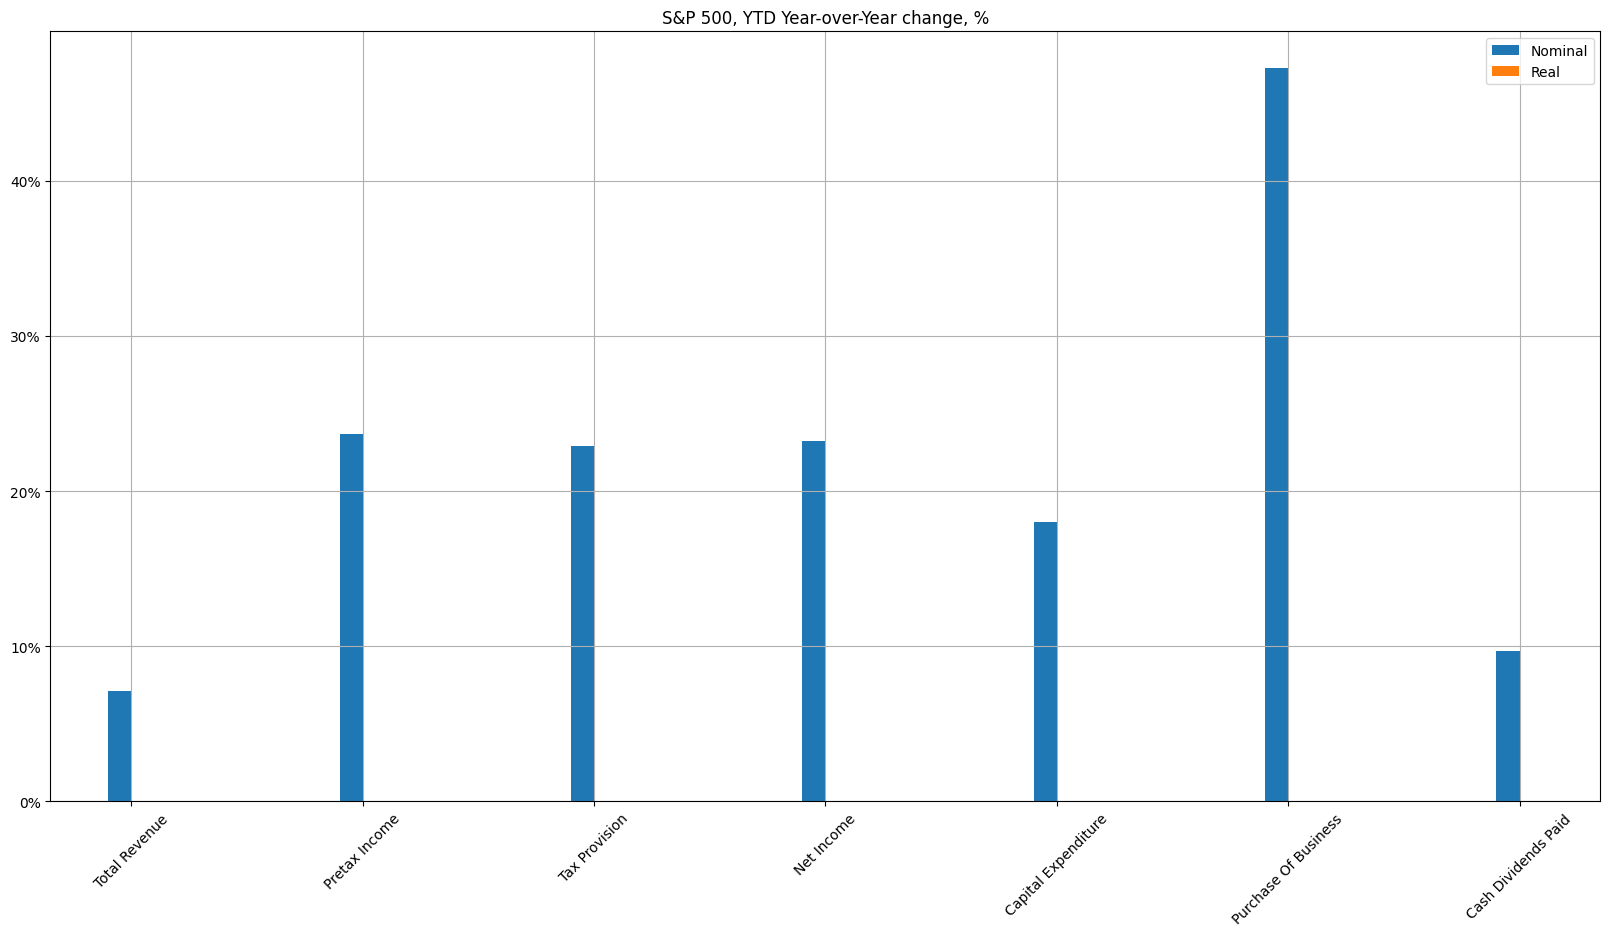

In [71]:
ax = yoy_growth.plot.bar(figsize=(20,10), grid=True, rot=45, width=0.2,
                         title=f'S&P 500, YTD Year-over-Year change, %')
ax.yaxis.set_major_formatter('{x:,.0%}')

In [34]:
sector_istmt['utilities']

,2025-09-30,2025-06-30,2025-03-31,2024-12-31,2024-09-30
Total Revenue,"$124,983,240,000.00bn","$108,736,874,000.00bn","$123,376,656,000.00bn","$105,786,921,000.00bn","$116,663,345,000.00bn"
Pretax Income,"$22,044,904,000.00bn","$14,690,290,000.00bn","$18,138,128,000.00bn","$12,873,899,000.00bn","$19,739,108,000.00bn"
Net Income,"$20,006,372,000.00bn","$13,470,675,000.00bn","$16,697,642,000.00bn","$12,790,713,000.00bn","$18,193,979,000.00bn"
Tax Provision,"$2,682,146,000.00bn","$1,855,629,000.00bn","$2,128,100,000.00bn","$710,100,000.00bn","$2,410,643,000.00bn"
Capital Expenditure,"$-45,060,725,000.00bn","$-45,138,513,000.00bn","$-40,897,810,000.00bn","$-45,218,284,000.00bn","$-39,289,710,000.00bn"
Purchase Of Business,"$-860,647,000.00bn","$-669,537,000.00bn","$-1,042,904,000.00bn","$-2,668,337,000.00bn","$-738,197,000.00bn"
Cash Dividends Paid,"$-9,331,131,000.00bn","$-8,651,011,000.00bn","$-9,756,491,000.00bn","$-8,784,938,000.00bn","$-8,724,615,000.00bn"


In [46]:
for key, df in sector_istmt.items():
    print(key)
    yoy_growth = df.iloc[:,::-1].pct_change(4, axis=1, fill_method=None)
    yoy_growth = yoy_growth.reindex(yoy_growth.index[[0,1,3,2,4,5,6]])
    print(yoy_growth. iloc[:,-1])

utilities
Total Revenue           7.13%
Pretax Income          11.68%
Tax Provision          11.26%
Net Income              9.96%
Capital Expenditure    14.69%
Purchase Of Business   16.59%
Cash Dividends Paid     6.95%
Name: 2025-09-30 00:00:00, dtype: float64
financial-services
Total Revenue          -10.17%
Pretax Income            3.31%
Tax Provision            7.57%
Net Income               0.72%
Capital Expenditure    -33.80%
Purchase Of Business   $9.08bn
Cash Dividends Paid      8.84%
Name: 2025-09-30 00:00:00, dtype: float64
healthcare
Total Revenue           11.60%
Pretax Income            9.32%
Tax Provision           47.98%
Net Income              -5.24%
Capital Expenditure     -8.61%
Purchase Of Business   -64.96%
Cash Dividends Paid      9.21%
Name: 2025-09-30 00:00:00, dtype: float64
technology
Total Revenue           47.99%
Pretax Income           83.55%
Tax Provision          -18.13%
Net Income             154.04%
Capital Expenditure     36.86%
Purchase Of Business   2

In [75]:
# import pickle
# path = os.path.expanduser("~/historical_equity_data/sp500_quarterly_stmts_sectors.pkl")
# with open(path, 'rb') as f:
#     sector_istmt_old = pickle.load(f)

# new_map = {}
# for key, df in sector_istmt.items():
#     # print(key)
#     if key in sector_istmt_old:
#         new_map[key] = pd.concat([sector_istmt[key].iloc[:,0], sector_istmt_old[key]], axis=1)
#     else:
#         new_map[key] = df

In [74]:
# with open(path, 'wb') as f:
#     pickle.dump(new_map, f)